# COVID-19 ABM Simulations

### Chirag Kumar - 20.09.2020

### This script develops and tests interventions for COVID-19 spread simulated using an ABM.

## Prep Workspace

### Import and Set-up Packages: Python and R

In [1]:
# python packages
import pandas as pd # for dataframes
import numpy as np # for arrays
import matplotlib.pyplot as plt # for plotting
import matplotlib as mpl # for matplotlib settings
import os # for directories
#import rpy2 # for running r commands - namely plotting
from scipy.optimize import minimize # for optimization of noisy functions
#from sodapy import Socrata # for quering CDC data
#from ddf_utils.factory.ihme import IHMELoader # for quering GHDx data
import scipy as sp # useful to have the whole library to access
from scipy import stats # for statistics and distributions
from scipy import integrate # for numerical integration processes
from scipy import signal # for finding peaks in data
from scipy import optimize # for optimizing functions
from sklearn.linear_model import LinearRegression # for easy linear regression
#import statsmodels.formula.api as smf # for GLMs
import statsmodels.api as sm
from tqdm.auto import tqdm # for progress bars
from tqdm.contrib.concurrent import process_map # for multiprocessing with progress bars
import pickle # for serializing objects
#import datetime # for time series data
#import pathos # for multiprocessing
#import multiprocess # for multiprocessing
#import multiprocessing
#import numba # for fast compiling
from mesa import Model, Agent
from mesa.time import RandomActivation
from mesa.space import SingleGrid, MultiGrid
from mesa.datacollection import DataCollector
#from mesa.visualization.modules import CanvasGrid
#from mesa.visualization.ModularVisualization import ModularServer
#from mesa.batchrunner import BatchRunner
#from mesa.batchrunner import BatchRunnerMP

In [2]:
# configure plotting
%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 12]
font = {'family' : 'Nimbus Roman',
        'weight' : 'bold',
        'size'   : 22}

mpl.rc('font', **font)

### Define Directories

In [3]:
# define directories

# this is a hack to be able to refer to relative locations
if '__file__' not in globals():
    __file__ = '.'

inp_dir = os.path.abspath(os.path.dirname(__file__))
data_dir = os.path.abspath(os.path.join(os.path.dirname(__file__),
                                        'Data'))
out_dir = os.path.abspath(os.path.join(os.path.dirname(__file__),
                                       'Result Files'))
fig_dir = os.path.abspath(os.path.join(os.path.dirname(__file__),
                                          'Figures'))

### Get Data

#### COVID Cases by Age and Gender - Laxminarayan et al. (2020)

In [4]:
covid_cases_ag = pd.read_csv(os.path.join(data_dir, 'covid_cases-India.csv'))

In [5]:
covid_cases_ag = covid_cases_ag.drop(['Unnamed: 0', 'agegrp', 'dist'], axis = 1)

In [6]:
covid_cases_ag = covid_cases_ag[np.logical_or(covid_cases_ag.sex == 'M',
                                              covid_cases_ag.sex == 'F')]

In [7]:
covid_cases_ag.age = round(covid_cases_ag.age).astype(int)

In [8]:
covid_cases_ag['count'] = 1

In [9]:
tt1 = covid_cases_ag.groupby(['age', 'sex']).count()

In [10]:
tt1 = tt1.loc[:100, :]

In [11]:
tt1 = pd.DataFrame(tt1.values.reshape((-1, 2)))

In [12]:
tt1.index = [str(i) for i in range(100)]

tt1.columns = ['Female', 'Male']

In [13]:
covid_cases_age_gender = tt1.copy(deep = True)

In [14]:
# the CFR analysis only considers a subset of 102,569 + 22,315 cases

In [15]:
covid_cases_age_gender = covid_cases_age_gender * ((102569 + 22315) / covid_cases_age_gender.sum().sum())

#### COVID Deaths (India) by Age and Gender - Laxminarayan et al. (2020)

In [16]:
covid_CFRs = pd.read_csv(os.path.join(data_dir, 'covid_CFRs-India.csv'))

In [17]:
covid_CFRs['covid_19_deaths'] /= 100

In [18]:
covid_deaths_ag = covid_CFRs.copy(deep = True)

In [19]:
age_groups_overall_covid_deaths = {'65-74 years' : list(range(65, 75)),
                                  '85+ years' : list(range(85, 100)),
                                  '50-64 years' : list(range(50, 65)),
                                  '75-84 years' : list(range(75, 85)),
                                  '30-39 years' : list(range(30, 40)),
                                  '18-29 years' : list(range(18, 30)),
                                  '0-4 years' : list(range(0, 5)),
                                  '5-17 years' : list(range(5, 18)),
                                  '40-49 years' : list(range(40, 50))}

In [20]:
# turn the CFRs into actual estimated numbers of deaths
# note - we basically undo this later when computing probability of death
# but easy to do it now and just keep that code the same
covid_deaths_ag.covid_19_deaths = [float(covid_deaths_ag[np.logical_and(covid_deaths_ag.sex == sex,
                                                                 covid_deaths_ag.age_group_new == age_group)].covid_19_deaths) * sum([covid_cases_age_gender.loc[str(age),
                                                                 sex] for age in age_groups_overall_covid_deaths[age_group]]) for sex,
                                   age_group in zip(covid_deaths_ag.sex, covid_deaths_ag.age_group_new)]

#  / (1 + float(covid_deaths_ag[np.logical_and(covid_deaths_ag.sex == sex,
#                                                                  covid_deaths_ag.age_group_new == age_group)].covid_19_deaths))

In [21]:
covid_deaths_age_gender = covid_deaths_ag

In [22]:
covid_deaths_age_gender['covid_19_deaths'].sum()

2586.0135310549317

#### COVID Deaths (India) by Comorbidities - Laxminarayan et al. (2020)

In [23]:
covid_deaths_cm = pd.read_csv(os.path.join(data_dir, 'covid_comorbidities-India.csv'))

In [24]:
tt1 = covid_deaths_cm[covid_deaths_cm.condition == 'Diabetes mellitus']

In [25]:
tt1.loc[:, 'condition'] = 'COVID-19'

/Genomics/grid/users/ckkumar/.conda/envs/research_defaults/lib/python3.8/site-packages/pandas/core/indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


In [26]:
tt1.loc[:, 'number_covid19_deaths'] = [5, 50, 379, 1764, 1119, 590, 154, 12, 37, 152, 705, 455, 224, 51]

/Genomics/grid/users/ckkumar/.conda/envs/research_defaults/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


In [27]:
tt1['number_covid19_deaths'] -= [2, 14, 166, 1090, 754, 388, 102, 4, 14, 81, 450, 317, 151, 28]

<ipython-input-27-2eca3c4305e9>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tt1['number_covid19_deaths'] -= [2, 14, 166, 1090, 754, 388, 102, 4, 14, 81, 450, 317, 151, 28]


In [28]:
covid_deaths_comorbidities = pd.concat([covid_deaths_cm, tt1], axis = 0)

#### Data on Comorbidities Prevalence (US) - GHBx

In [29]:
# read the comorbidities data that ruchita gave me...
# these are prevalence values, not incidences
comorbidities_prevalence = pd.read_csv(os.path.join(data_dir,
                                                    'IHME-GBD_2019_DATA-9d448034-India.csv'))

In [30]:
# take just the variable i need
comorbidities_prevalence = comorbidities_prevalence.loc[:, ['sex', 'age', 'cause', 'val']]

In [31]:
# add hypertension
# Prevalence of hypertension among Indian adults: Results from thegreat India blood pressure survey

tt1 = comorbidities_prevalence.loc[comorbidities_prevalence.cause == 'Ischemic heart disease', :]
tt1.loc[:, 'cause'] = 'Hypertension'

tt1.val = np.nan

tt2 = np.logical_or(np.logical_or(np.logical_or(tt1.age == '20 to 24',
                                                tt1.age == '25 to 29'),
                                  tt1.age == '30 to 34'),
                   tt1.age == '35 to 39')

tt2 = np.logical_or(tt2, tt1.age == '40 to 44')

tt1.loc[np.logical_and(tt2, tt1.sex == 'Male'), 'val'] = .14
tt1.loc[np.logical_and(tt2, tt1.sex == 'Female'), 'val'] = .267

tt2 = np.logical_or(np.logical_or(np.logical_or(tt1.age == '45 to 49',
                                                tt1.age == '45 to 49'),
                                  tt1.age == '50 to 54'),
                   tt1.age == '50 to 54')

tt1.loc[np.logical_and(tt2, tt1.sex == 'Male'), 'val'] = .346
tt1.loc[np.logical_and(tt2, tt1.sex == 'Female'), 'val'] = .424

tt2 = np.logical_or(np.logical_or(np.logical_or(tt1.age == '55 to 59',
                                                tt1.age == '60 to 64'),
                                  tt1.age == '55 to 59'),
                   tt1.age == '60 to 64')

tt1.loc[np.logical_and(tt2, tt1.sex == 'Male'), 'val'] = .49
tt1.loc[np.logical_and(tt2, tt1.sex == 'Female'), 'val'] = .454

tt2 = np.logical_or(np.logical_or(np.logical_or(tt1.age == '65 to 69',
                                                tt1.age == '65 to 69'),
                                  tt1.age == '70 to 74'),
                   tt1.age == '70 to 74')

tt1.loc[np.logical_and(tt2, tt1.sex == 'Male'), 'val'] = .515
tt1.loc[np.logical_and(tt2, tt1.sex == 'Female'), 'val'] = .514


tt2 = np.logical_or(np.logical_or(np.logical_or(np.logical_or(tt1.age == '75 to 79',
                                                tt1.age == '80 to 84'),
                                  tt1.age == '85 to 89'),
                   tt1.age == '90 to 94'),
                   tt1.age == '95 plus')

tt1.loc[np.logical_and(tt2, tt1.sex == 'Male'), 'val'] = .522
tt1.loc[np.logical_and(tt2, tt1.sex == 'Female'), 'val'] = .513

# study only gives ages 18-19 --- assume all people below age 18-19 and including 18-19 have the same values
# of hypertension as 18-19 year olds

tt1[np.logical_and(np.isnan(tt1.val), tt1.sex == 'Male')] = 0.161
tt1[np.logical_and(np.isnan(tt1.val), tt1.sex == 'Female')] = 0.062

comorbidities_prevalence = pd.concat([comorbidities_prevalence,
                                     tt1], axis = 0)

/Genomics/grid/users/ckkumar/.conda/envs/research_defaults/lib/python3.8/site-packages/pandas/core/generic.py:5168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
<ipython-input-31-f4e13e045c7e>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tt1[np.logical_and(np.isnan(tt1.val), tt1.sex == 'Male')] = 0.161
<ipython-input-31-f4e13e045c7e>:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

In [32]:
# add hyper/hypothyroidism data
# Hypothyroidism in India: more to be done
# Thyroid disorders in India: An epidemiological perspective

# no breakdown of values given unfortunately

tt1 = comorbidities_prevalence.loc[comorbidities_prevalence.cause == 'Ischemic heart disease', :]
tt1.loc[:, 'cause'] = 'Hyperthyroidism or hypothyroidism'

tt1.val = .11 + .016 + .013

comorbidities_prevalence = pd.concat([comorbidities_prevalence,
                                     tt1], axis = 0)

#### Testing Effectiveness

In [33]:
# turn them into a nice dataframe
testing_effectiveness = pd.DataFrame(columns = ['sensitivity',
                                                'specificity'], index = ['rt-pcr',
                                                                         'antibody',
                                                                        'antigen'])
# recall sensitivity is true positives / (true pos + false negs)
# recall specificity is true negatives / (true negs + false positive)
testing_effectiveness.loc['rt-pcr', 'sensitivity'] = 1 # it's 1 because of the constraints for testing positive discussed below
testing_effectiveness.loc['rt-pcr', 'specificity'] = .99 # https://www.cell.com/med/pdf/S2666-6340(20)30016-7.pdf
# https://onlinelibrary.wiley.com/doi/pdf/10.1002/jmv.26211?casa_token=o2avJ_hHuagAAAAA%3ApBIZmAW7hn4vwT4rO5xWKP2CqjGo34TkkcVQ_EZ1_JtmLG_p_A4KLOlUvcOtekHDSvGUMIbUVTxrKAFO
testing_effectiveness.loc['antibody', 'sensitivity'] = .96
testing_effectiveness.loc['antibody', 'specificity'] = 0.95
# Comparison of automated SARS-CoV-2 antigen test for COVID-19 infection with quantitative RT-PCR using 313 nasopharyngeal
# swabs, including from seven serially followed patients
testing_effectiveness.loc['antigen', 'sensitivity'] = [1, 0.6, 0.33, 0.26] # sensitivity for >2, 1-2, 0-1, <0 viral loads
testing_effectiveness.loc['antigen', 'specificity'] = 1

#### Probability of Transmission Over Time

In [34]:
bootstrapped_gamma_params = pd.read_csv(os.path.join(data_dir,
                                                     'InfectiousnessGamaDistributionBootstrappedParameters.csv'))
bootstrapped_gamma_params = bootstrapped_gamma_params.drop('Unnamed: 0', axis = 1)

#### Viral Load Over Time

In [35]:
# units of log10 copies per mL
viral_load = pd.read_csv(os.path.join(data_dir,
                                      'ViralLoadDaysSinceSymptomOnsetMetaAnalysis-SpatialTemporalDynamics.csv'))
viral_load = viral_load.loc[np.logical_and(viral_load.Swab == 'URT',
                                          True), :]
viral_load = viral_load.drop(['Author'], axis = 1)

In [36]:
viral_load_kinetics = sm.OLS(viral_load['Viral_load_log10'][~np.isnan(viral_load['Viral_load_log10'])][viral_load['Day'] > 3],
        np.vstack((np.ones(viral_load['Day'][~np.isnan(viral_load['Viral_load_log10'])][viral_load['Day'] > 3].values.shape),
                       viral_load['Day'][~np.isnan(viral_load['Viral_load_log10'])][viral_load['Day'] > 3].values)).T).fit()

In [37]:
viral_load_ct = LinearRegression().fit(np.array([0.91, 10.42]).reshape(-1, 1),
                                       np.array([37.92, 6.16]).reshape(-1, 1))

In [38]:
ct_viral_load = LinearRegression().fit(np.array([37.92, 6.16]).reshape(-1, 1),
                                       np.array([0.91, 10.42]).reshape(-1, 1))

#### Contacts Distribution

In [39]:
# number of contacts
k = 0.51
m = 2.5
Xs = np.array(range(101))

p_contacts = (sp.special.gamma(k + Xs) / (sp.special.gamma(Xs + 1) * sp.special.gamma(k))) * (np.power(m / (m + k),
                                                                                                       Xs)) * ((1 + (m / k)) ** (-k))

p_contacts = p_contacts[1:]

#### Duration and Length of Hospital Stay

In [40]:
# computed negative binomial parameters
duration_nbinom_parameters = pd.read_csv(os.path.join(data_dir, 'NegativeBinomialDistributionParameters.csv'))

In [41]:
duration_nbinom_parameters.index = ['critical_duration<=49',
                                   'death_hospital<=49',
                                   'critical_duration<=64',
                                   'death_hospital<=64',
                                   'critical_duration>64',
                                   'death_hospital>64',
                                   'duration_overall',
                                   'hospital<=49',
                                   'icu<=49',
                                   'hospital<=64',
                                   'icu<=64',
                                   'hospital>64',
                                   'icu>64']

### Contact Matrix

In [42]:
contact = pd.read_csv(os.path.join(data_dir, 'ContactMatrixCOVIDIndiaAllContacts.csv'))

In [43]:
contact = contact.drop(['Unnamed: 0'], axis = 1)

In [44]:
contact.index = ['1 to 4', '5 to 9', '10 to 14', '15 to 19', '20 to 24', '25 to 29', '30 to 34',
                 '35 to 39', '40 to 44', '45 to 49', '50 to 54', '55 to 59', '60 to 64', '65 to 69',
                 '70 to 74', '75 to 79', '80+']

In [45]:
contact.columns = ['1 to 4', '5 to 9', '10 to 14', '15 to 19', '20 to 24', '25 to 29', '30 to 34',
                 '35 to 39', '40 to 44', '45 to 49', '50 to 54', '55 to 59', '60 to 64', '65 to 69',
                 '70 to 74', '75 to 79', '80+']

## Process Data

In [46]:
# standardize the data from various sources so that it is all interchangeable
# recall that each dataset uses a different set of age groups
# i make dictionaries that map the age groups to specific ages for each dataset

# make a dictionary that links the age groups to ages

age_groups_comorbidities_covid_deaths = {'65-74y' : list(range(65, 75)),
                                  '85+y' : list(range(85, 100)),
                                  '45-64y' : list(range(45, 65)),
                                  '30-44y' : list(range(30, 45)),
                                  '75-84y' : list(range(75, 85)),
                                  '18-29y' : list(range(18, 30)),
                                  '0-17y' : list(range(0, 18))}

age_groups_comorbidities = {'1 to 4' : list(range(0, 5)),
                            '5 to 9' : list(range(5, 10)),
                            '10 to 14' : list(range(10, 15)),
                            '15 to 19' : list(range(15, 20)),
                            '20 to 24' : list(range(20, 25)),
                            '25 to 29' : list(range(25, 30)),
                            '30 to 34' : list(range(30, 35)),
                            '35 to 39' : list(range(35, 40)),
                            '40 to 44' : list(range(40, 45)),
                            '45 to 49' : list(range(45, 50)),
                            '50 to 54' : list(range(50, 55)),
                            '55 to 59' : list(range(55, 60)),
                            '60 to 64' : list(range(60, 65)),
                            '65 to 69' : list(range(65, 70)),
                            '70 to 74' : list(range(70, 75)),
                            '75 to 79' : list(range(75, 80)),
                            '80 to 84' : list(range(80, 85)),
                            '85 to 89' : list(range(85, 90)),
                            '90 to 94' : list(range(90, 95)),
                            '95 plus' : list(range(95, 111))}

age_groups_contacts = {'1 to 4' : list(range(0, 5)),
                       '5 to 9' : list(range(5, 10)),
                       '10 to 14' : list(range(10, 15)),
                       '15 to 19' : list(range(15, 20)),
                       '20 to 24' : list(range(20, 25)),
                       '25 to 29' : list(range(25, 30)),
                       '30 to 34' : list(range(30, 35)),
                       '35 to 39' : list(range(35, 40)),
                       '40 to 44' : list(range(40, 45)),
                       '45 to 49' : list(range(45, 50)),
                       '50 to 54' : list(range(50, 55)),
                       '55 to 59' : list(range(55, 60)),
                       '60 to 64' : list(range(60, 65)),
                       '65 to 69' : list(range(65, 70)),
                       '70 to 74' : list(range(70, 75)),
                       '75 to 79' : list(range(75, 80)),
                       '80+' : list(range(80, 111))}

In [47]:
# Finally, make a comorbidities dictionary that maps the comorbidities in the covid deaths data to the
# comorbdities for which we have prevalence

comorbidities_aggregate = {'Diabetes mellitus' : ['Diabetes mellitus'],
                           'Hypertension' : ['Sustained hypertension'],
                           'Ischemic heart disease' : ['Coronary artery disease'],
                           'Chronic kidney disease' : ['Renal disease'],
                           'Chronic obstructive pulmonary disease' : ['Chronic obstructive pulmonary disease'],
                           'Asthma' : ['Asthma'],
                           'Neoplasms' : ['Cancer'],
                           'Tuberculosis' : ['Pulmonary tuberculosis'],
                           'Stroke' : ['Stroke'],
                           'Hyperthyroidism or hypothyroidism' : ['Hyperthyroidism or hypothyroidism'],
                           'Cirrhosis and other chronic liver diseases' : ['Liver disease'],
                           None : ['COVID-19']}

## Set Population Profile and COVID Testing Scenario

In [48]:
# set age and gender from us census
age_gender_profile = pd.read_csv(os.path.join(data_dir, 'india-districts-census-2011.csv'))

In [49]:
age_gender_profile = age_gender_profile[age_gender_profile['District name'].isin(['Anantapur',
                                                                                  'Chittoor',
                                                                                  'East Godavari',
                                                                                  'Guntur',
                                                                                  'Krishna',
                                                                                  'Kurnool',
                                                                                  'Nellore',
                                                                                  'Prakasam',
                                                                                  'Srikakulam',
                                                                                  'Visakhapatnam'
                                                                                  'Vizianagaram',
                                                                                  'West Godavari',
                                                                                 'Y.S.R',
                                                                                 'Ariyalur',
                                                                                  'Chennai',
                                                                                  'Coimbatore',
                                                                                  'Cuddalore',
                                                                                  'Dharmapuri',
                                                                                  'Dindigul',
                                                                                  'Erode',
                                                                                  'Kancheepuram',
                                                                                  'Kanniyakumari',
                                                                                  'Karur',
                                                                                  'Krishnagiri',
                                                                                  'Madurai',
                                                                                  'Nagappattinam',
                                                                                  'Namakkal',
                                                                                  'The Nilgiris',
                                                                                  'Perambalur',
                                                                                  'Pudukkottai',
                                                                                  'Ramanathapuram',
                                                                                  'Salem',
                                                                                  'Sivaganga',
                                                                                  'Thanjavur',
                                                                                  'Theni',
                                                                                  'Thirupathur',
                                                                                  'Thiruvalur',
                                                                                  'Thiruvarur',
                                                                                  'Thoothukkudi',
                                                                                  'Tiruchirappalli',
                                                                                  'Tirunelveli',
                                                                                  'Tiruppur',
                                                                                  'Thiruvannamalai',
                                                                                  'Vellore',
                                                                                  'Villuppuram',
                                                                                  'Virudhunagar'])]

In [50]:
age_gender_profile = age_gender_profile[['Male', 'Female']]

In [51]:
age_gender_profile = age_gender_profile.sum()

In [52]:
age_gender_profile = age_gender_profile / age_gender_profile.sum()

In [53]:
tt1 = np.array([[8496750, 22980256, 25987179, 20783627, 19153878, 20532992, 6925674, 2403009, 608554]]).T

In [54]:
age_gender_profile = age_gender_profile.values.reshape((1, -1))

In [55]:
age_gender_profile = np.matmul(tt1, age_gender_profile)

In [56]:
age_gender_profile = pd.DataFrame(age_gender_profile, columns = ['Male', 'Female'])

In [57]:
age_gender_profile.index = ['0-4 years', '5-17 years', '18-29 years', '30-39 years', '40-49 years',
                           '50-64 years', '65-74 years', '75-84 years', '85+ years']

In [58]:
tt1 = pd.DataFrame(columns = ['Male', 'Female'])

In [59]:
for age_range in age_gender_profile.index:
    temp = age_gender_profile.loc[age_range, :]
    if age_range != '85+ years':
        for age in range(int(age_range.split(' ')[0].split('-')[0]),
                         int(age_range.split(' ')[0].split('-')[1]) + 1):
            tt1.loc[age, :] = temp
    else:
        for age in range(85, 100):
            tt1.loc[age, :] = temp

In [60]:
age_gender_profile = tt1

In [61]:
class cost(object):    
    def __init__(self):
        self.running_total = 0.0
        
    # https://www.wsj.com/articles/covid-19-tests-answers-on-cost-accuracy-and-turnaround-time-11599134378
    def rt_pcr(self):
        self.running_total += 180.0
        
    def antigen(self):
        self.running_total += 5.0 # also kinda an estimate
        
    def quarantine(self):
        self.running_total += 0.0
        
    def antibody(self):
        self.running_total += 5.0 # really an estimate
        
    def icu(self):
        self.running_total += 0.0
        
    def hospital(self):
        self.running_total += 0.0
        
    def death(self):
        self.running_total += 0.0

In [62]:
class mitigation():
    """Various testing/quarantining/etc scenarios"""
    def __init__(self, testing_effectiveness, groups, period):
        self.groups = groups
        self.period = period
        self.testing_effectiveness = testing_effectiveness
        self.chunks = list(range(self.groups))
        self.testing = False
        self.current_chunk = self.chunks[0]
        self.cost = cost()
        
    # baseline scenario - no safety measures at all
    # trump strategy
    def baseline(self, agent, i):
        return None
    
    # randomly test people - small college strategy
    def rt_pcr_random(self, agent, N):
        # the people get tested once a cycle with each group getting tested
        if N % self.period == 0 and agent.unique_id % self.groups == self.current_chunk: # test this group of agents
            self.cost.rt_pcr()
            if agent.infection_course != None and np.random.uniform(low = 0.0,
                                                            high = 1.0,
                                                            size = 1)[0] <= self.testing_effectiveness.loc['rt-pcr',
                                                                                                          'sensitivity']:
                current_viral_load = agent.infection_course['viral_load'][int(agent.infection_course['days_since_exposure'])]
                
                # minimum level of detectability is about 0.91 log10 copies per mL from this paper:
                # https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7235577/pdf/main.pdf
                
                if current_viral_load > 0.91:
                    return True
            if agent.state != 'dead' and np.random.uniform(low = 0.0,
                                                             high = 1.0,
                                                             size = 1)[0] >= self.testing_effectiveness.loc['rt-pcr',
                                                                                                          'specificity']:
                return True
            else:
                return False
                    
            self.testing = True
            
        elif self.testing:
            self.testing = False
            self.current_chunk = self.chunks[(self.chunks.index(self.current_chunk) + 1) % len(self.chunks)]
        
    # test those who are symptomatic only
    def rt_pcr_symptom_expressing(self, agent, N):
        if agent.state == 'infected-s' or agent.state == 'hospitalized':
            self.cost.rt_pcr()
            
            current_viral_load = agent.infection_course['viral_load'][int(agent.infection_course['days_since_exposure'])]
            
            if current_viral_load > 0.91 and np.random.uniform(low = 0.0, high = 1.0,
                                             size = 1)[0] <= self.testing_effectiveness.loc['rt-pcr',
                                                                                                  'sensitivity']:
                return True
            if current_viral_load <= 0.91 and np.random.uniform(low = 0.0,
                                                                high = 1.0,
                                                                size = 1)[0] >= self.testing_effectiveness.loc['rt-pcr',
                                                                                                  'specificity']:
                return True
            else:
                return False
            
    def rt_pcr(self, agent):
        self.cost.rt_pcr()
        if agent.infection_course != None and np.random.uniform(low = 0.0,
                                                            high = 1.0,
                                                            size = 1)[0] <= self.testing_effectiveness.loc['rt-pcr',
                                                                                                          'sensitivity']:
            current_viral_load = agent.infection_course['viral_load'][int(agent.infection_course['days_since_exposure'])]
                
            # minimum level of detectability is about 0.91 log10 copies per mL from this paper:
            # https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7235577/pdf/main.pdf
                
            if current_viral_load > 0.91:
                return True
        if agent.state != 'dead' and np.random.uniform(low = 0.0,
                                                             high = 1.0,
                                                             size = 1)[0] >= self.testing_effectiveness.loc['rt-pcr',
                                                                                                          'specificity']:
            return True
        else:
            return False
            
    def antigen_random(self, agent, N):
        # the people get tested once a cycle with each group getting tested
        if N % self.period == 0 and agent.unique_id % self.groups == self.current_chunk: # test this group of agents
            self.cost.antigen()
            if agent.infection_course != None:
                
                sensitivities = self.testing_effectiveness.loc['antigen', 'sensitivity']
                
                randn = np.random.uniform(low = 0.0, high = 1.0)
                
                current_viral_load = agent.infection_course['viral_load'][int(agent.infection_course['days_since_exposure'])]
                
                if current_viral_load > 2 and randn < sensitivities[0]:
                    return True
                elif current_viral_load > 1 and randn < sensitivities[1]:
                    return True
                elif current_viral_load > 0 and randn < sensitivities[2]:
                    return True
                elif current_viral_load <= 0 and randn < sensitivities[3]:
                    return True
            if agent.state != 'dead' and np.random.uniform(low = 0.0,
                                                             high = 1.0,
                                                             size = 1)[0] >= self.testing_effectiveness.loc['antigen',
                                                                                                          'specificity']:
                return True
            else:
                return False
                    
            self.testing = True
            
        elif self.testing:
            self.testing = False
            self.current_chunk = self.chunks[(self.chunks.index(self.current_chunk) + 1) % len(self.chunks)]
                
    # test those who are symptomatic only
    def antigen_symptom_expressing(self, agent, N):
        if agent.state == 'infected-s' or agent.state == 'hospitalized':
            self.cost.antigen()
            
            sensitivities = self.testing_effectiveness.loc['antigen', 'sensitivity']
                
            randn = np.random.uniform(low = 0.0, high = 1.0)
                
            current_viral_load = agent.infection_course['viral_load'][int(agent.infection_course['days_since_exposure'])]
                
            if current_viral_load > 2 and randn < sensitivities[0]:
                return True
            elif current_viral_load > 1 and randn < sensitivities[1]:
                return True
            elif current_viral_load > 0 and randn < sensitivities[2]:
                return True
            elif current_viral_load <= 0 and randn < sensitivities[3]:
                return True
        if agent.state != 'dead' and np.random.uniform(low = 0.0,
                                                             high = 1.0,
                                                             size = 1)[0] >= self.testing_effectiveness.loc['antigen',
                                                                                                          'specificity']:
            return True
        else:
            return False
                
    def antibody(self, agent):
        self.cost.antibody()
        if agent.state == 'recovered':
            if np.random.uniform(low = 0.0, high = 1.0, size = 1)[0] >= self.testing_effectiveness.loc['antibody',
                                                                                                  'sensitivity']:
                return False
            else:
                return True
        elif np.random.uniform(low = 0.0, high = 1.0) <= self.testing_effectiveness.loc['antibody',
                                                                                        'specificity']:
            return False
        else:
            return True

In [63]:
class scenario_details():
    """Holds the details required to specify the COVID transmission scenario explored"""
    
    def __init__(self,
                 comorbidities_distribution, prop_healthy, # population characteristics
                 spreader_prop,
                 cases_age_gender, risk_death_distribution, transmission_probability, # disease characteristics
                 mitigation_strategy, # testing scenario
                 external_connectivity, steps_per_day): # model parameters
        
        # define all the variables in this class as properties for easy access
        self.comorbidities_distribution = comorbidities_distribution # prob of each comorbidity by age,sex
        self.prop_healthy = prop_healthy
        self.spreader_prop = spreader_prop
        self.cases_age_gender = cases_age_gender # cases by age and gender
        self.risk_death_distribution = risk_death_distribution # risk of death for each age, sex, and comorbidity
        self.mitigation_strategy = mitigation_strategy # the testing scenario implemented in the current scenario
        self.external_connectivity = external_connectivity # prob that agents may get covid externally
        self.steps_per_day = steps_per_day # the chunks into which time is discretized
        
        # risk of death distribution is a tuple so break it up into its parts
        self.deaths_ag = risk_death_distribution[0]
        self.deaths_co = risk_death_distribution[1]
        
    # draw a random age from the age distribution
    def rnd_age(self):
        return np.random.choice(age_gender_profile.index,
                                p = age_gender_profile.sum(axis = 1) / age_gender_profile.sum(axis = 1).sum(axis = 0))
    
    # draw a random gender from the gender distribution
    def rnd_gender(self, age):
        gender_distribution = age_gender_profile.loc[age, :]
        if np.random.choice([0, 1], p = gender_distribution / gender_distribution.sum()) == 0:
            return 'Male'
        else:
            return 'Female'
    
    # based on age and gender, give the agent comorbidities
    def rnd_comorbidities(self, age, gender):
        # get risk of comorbidities based on age, gender
        # go from age number to an age range name in the comorbidities data
        age_range_name = [k for k, v in age_groups_comorbidities.items() if int(age) in v][0]
        
        # ramanan's paper details the percentage of people that have any comorbidity:
        randn = np.random.uniform(low = 0.0, high = 1.0)
        
        if age < 18:
            if gender == 'Male' and randn > 0.4:
                return [None]
            elif gender == 'Female' and randn > 0.33:
                return [None]
        elif age < 30:
            if gender == 'Male' and randn > .28:
                return [None]
            elif gender == 'Female' and randn > 0.38:
                return [None]
        elif age < 45:
            if gender == 'Male' and randn > 0.44:
                return [None]
            elif gender == 'Female' and randn > 0.53:
                return [None]
        elif age < 65:
            if gender == 'Male' and randn > 0.62:
                return [None]
            elif gender == 'Female' and randn > 0.64:
                return [None]
        elif age < 75:
            if gender == 'Male' and randn > 0.67:
                return [None]
            elif gender == 'Female' and randn > 0.70:
                return [None]
        elif age < 85:
            if gender == 'Male' and randn > 0.66:
                return [None]
            elif gender == 'Female' and randn > 0.67:
                return [None]
        else:
            if gender == 'Male' and randn > 0.66:
                return [None]
            elif gender == 'Female' and randn > 0.55:
                return [None]
        
        # now we have people that have at least one comorbidity
        # from ramanan's paper, assume that the maximum number of comorbidities someone can have is 3
        
        randn = np.random.uniform(low = 0.0, high = 1.0)
        
        if age < 18:
            if gender == 'Male':
                if randn < 0 / .4:
                    num_comorbidities = 3
                elif randn < 0  / .4:
                    num_comorbidities = 2
                else:
                    num_comorbidities = 1
            elif gender == 'Female':
                if randn < 0 / .33:
                    num_comorbidities = 3
                elif randn < 0 / .33:
                    num_comorbidities = 2
                else:
                    num_comorbidities = 1
        
        elif age < 30:
            if gender == 'Male':
                if randn < 0 / 0.28:
                    num_comorbidities = 3
                elif randn < .08 / 0.28:
                    num_comorbidities = 2
                else:
                    num_comorbidities = 1
            elif gender == 'Female':
                if randn < .03 / 0.38:
                    num_comorbidities = 3
                elif randn < .08 / 0.38:
                    num_comorbidities = 2
                else:
                    num_comorbidities = 1
        
        elif age < 45:
            if gender == 'Male':
                if randn < .04 / 0.44:
                    num_comorbidities = 3
                elif randn < .16 / 0.44:
                    num_comorbidities = 2
                else:
                    num_comorbidities = 1
            elif gender == 'Female':
                if randn < .07 / 0.53:
                    num_comorbidities = 3
                elif randn < .21 / 0.53:
                    num_comorbidities = 2
                else:
                    num_comorbidities = 1
                    
        elif age < 65:
            if gender == 'Male':
                if randn < .11 / 0.62:
                    num_comorbidities = 3
                elif randn < .34 / 0.62:
                    num_comorbidities = 2
                else:
                    num_comorbidities = 1
            elif gender == 'Female':
                if randn < .12 / 0.64:
                    num_comorbidities = 3
                elif randn < .38 / 0.64:
                    num_comorbidities = 2
                else:
                    num_comorbidities = 1
                    
        elif age < 75:
            if gender == 'Male':
                if randn < .16 / 0.67:
                    num_comorbidities = 3
                elif randn < .42 / 0.67:
                    num_comorbidities = 2
                else:
                    num_comorbidities = 1
            elif gender == 'Female':
                if randn < .15 / 0.7:
                    num_comorbidities = 3
                elif randn < .41 / 0.7:
                    num_comorbidities = 2
                else:
                    num_comorbidities = 1
                    
        elif age < 85:
            if gender == 'Male':
                if randn < .17 / 0.66:
                    num_comorbidities = 3
                elif randn < .43 / 0.66:
                    num_comorbidities = 2
                else:
                    num_comorbidities = 1
            elif gender == 'Female':
                if randn < .14 / 0.67:
                    num_comorbidities = 3
                elif randn < .43 / 0.67:
                    num_comorbidities = 2
                else:
                    num_comorbidities = 1
                    
        else:
            if gender == 'Male':
                if randn < .16 / 0.66:
                    num_comorbidities = 3
                elif randn < .45 / 0.66:
                    num_comorbidities = 2
                else:
                    num_comorbidities = 1
            elif gender == 'Female':
                if randn < .12 / 0.55:
                    num_comorbidities = 3
                elif randn < .29 / 0.55:
                    num_comorbidities = 2
                else:
                    num_comorbidities = 1
        
        # now let us allocate comorbidities to the remaining people based on how many comorbidities assignment
        # treat comorbidities as independent
        
        # take a subset of the comorbdity data for only this agent's gender and age
        tt1 = np.logical_and(self.comorbidities_distribution.sex == gender,
                             self.comorbidities_distribution.age == age_range_name)
        temp = self.comorbidities_distribution.loc[tt1, :].reset_index(drop = True)
        
        comorbidities_agent = list(np.random.choice(temp.cause,
                                                    p = temp.val / temp.val.sum(),
                                                    size = num_comorbidities,
                                                    replace = False))
                
        return comorbidities_agent
        
    # based on age, gender, and comorbidities, determine the probability of death
    def risk_death(self, age, gender, comorbidities):
        # find overall chance of death given age and gender
        age_range_ = [k for k, v in age_groups_overall_covid_deaths.items() if int(age) in v][0]
        
        # subset just the part of the data that we are interested in 
        tt1 = np.logical_and(self.deaths_ag.sex == gender,
                             self.deaths_ag.age_group_new == age_range_)
        
        deaths_o = self.deaths_ag.loc[tt1, 'covid_19_deaths'].astype(int).values[0]
        
        # to convert to a probability, divide deaths by number of cases
        #age_range_name_cases = [k for k, v in age_groups_overall_covid_cases.items() if int(age) in v][0]
        p_death_o = deaths_o
        p_death_o /= self.cases_age_gender[gender][[str(aaa) for aaa in age_groups_overall_covid_deaths[age_range_]]].sum()
        
        # however, this gives us the death for people of this age and gender - need to add in comorbidities
        # i don't have cases by comorbidities, so find how much specific comorbidities increase the probability
        # of death compared to other comorbidities
        
        age_range_name = [k for k, v in age_groups_comorbidities_covid_deaths.items() if int(age) in v][0]
        
        conditions = list(map(comorbidities_aggregate.get, comorbidities))
        
        tt1 = np.logical_and(np.logical_and(self.deaths_co.condition.isin([condition[0] for condition in conditions]),
                             self.deaths_co.age_group == age_range_name),
                            self.deaths_co.sex == gender)
        
        deaths_c = self.deaths_co.loc[tt1, 'number_covid19_deaths'].astype(int).values[0]
        
        deaths_all_c = self.deaths_co.loc[np.logical_and(self.deaths_co.age_group == age_range_name,
                                                         self.deaths_co.sex == gender),
                                                      'number_covid19_deaths'].astype(int).sum()
        
        risk_increase = deaths_c * len(self.deaths_co.condition.unique()) / deaths_all_c
        
        return p_death_o * risk_increase / 2 # divide by 2 for gender normalization
    
    # create the course of the infection for the agent and store everything in a dictionary
    def infection_course(self, age, gender, comorbidities):
        # the infection course: incubation --> infectious-asy --? infectious-s --> R or D
        
        # first figure out for how long this agent will be in incubation
        # data from Incubation period of COVID-19: a rapid systematic review and meta-analysis of observational research
        # probability of symptom development is a lognormal with mu = 1.63 and sigma = 0.50
        incubation_days = round(stats.lognorm.rvs(s = 0.5, loc = 0, scale = np.exp(1.63), size = 1)[0])
        death = False
        # will this agent die?
        if np.random.uniform(low = 0.0, high = 1.0, size = 1)[0] <= self.risk_death(age,
                                                                                   gender,
                                                                                   comorbidities):
            death = True
            # now determine the duration of infection for this agent
            # for an agent that dies, assume that they go to the hospital first
            # at that point, they are no longer infectious
            # however, they may spend some time in the hospital before transitioning to dead
            
            # set a variable 'duration' for how long the individual is infectious - days until hospitalized
            # also set 'hospitalized_time' for how many days later the agent dies -- assume death in the hospital
            # https://www.cdc.gov/coronavirus/2019-ncov/hcp/planning-scenarios.html
            if age <= 49:
                duration = stats.nbinom.rvs(loc = 0,
                                        n = float(duration_nbinom_parameters.loc['critical_duration<=49',
                                                                                             :][0].split(' ')[0][1:]),
                                           p = float(duration_nbinom_parameters.loc['critical_duration<=49',
                                                                                    :][0].split(' ')[1][:-1]))
                hospitalized_time = stats.nbinom.rvs(loc = 0,
                                        n = float(duration_nbinom_parameters.loc['death_hospital<=49',
                                                                                             :][0].split(' ')[0][1:]),
                                           p = float(duration_nbinom_parameters.loc['death_hospital<=49',
                                                                                    :][0].split(' ')[1][:-1])) - duration
                
            elif age <= 64:
                duration = stats.nbinom.rvs(loc = 0,
                                        n = float(duration_nbinom_parameters.loc['critical_duration<=64',
                                                                                             :][0].split(' ')[0][1:]),
                                           p = float(duration_nbinom_parameters.loc['critical_duration<=64',
                                                                                    :][0].split(' ')[1][:-1]))
                hospitalized_time = stats.nbinom.rvs(loc = 0,
                                        n = float(duration_nbinom_parameters.loc['death_hospital<=64',
                                                                                             :][0].split(' ')[0][1:]),
                                           p = float(duration_nbinom_parameters.loc['death_hospital<=64',
                                                                                    :][0].split(' ')[1][:-1])) - duration
                
            else:
                duration = stats.nbinom.rvs(loc = 0,
                                        n = float(duration_nbinom_parameters.loc['critical_duration>64',
                                                                                             :][0].split('   ')[0][1:]),
                                           p = float(duration_nbinom_parameters.loc['critical_duration>64',
                                                                                    :][0].split('   ')[1][:-1]))
                hospitalized_time = stats.nbinom.rvs(loc = 0,
                                        n = float(duration_nbinom_parameters.loc['death_hospital>64',
                                                                                             :][0].split(' ')[0][1:]),
                                           p = float(duration_nbinom_parameters.loc['death_hospital>64',
                                                                                    :][0].split(' ')[1][:-1])) - duration
                
            hospitalized_time = hospitalized_time * (hospitalized_time > 0)
            duration = int(duration)
            hospitalized_time = int(hospitalized_time)
            
        else: # the agent can be asymptomatic wholly, symptomatic, and/or hospitalized with recovery
            
            # duration for this type of infection is relatively straightforward
            duration = stats.nbinom.rvs(loc = 0,
                                        n = float(duration_nbinom_parameters.loc['duration_overall',
                                                                                             :][0].split(' ')[0][1:]),
                                           p = float(duration_nbinom_parameters.loc['duration_overall',
                                                                                    :][0].split(' ')[1][:-1]))
            
            # determine whether agent if wholly asymptomatic
            
            # P(A) = 0.4 according to CDC website
            # want P(A | ~D) = P(~D | A) * P(A) / P(~D) = P(A) / P(~D)
            prob_asymptomatic = (.4 / (1 - self.risk_death(age, gender, comorbidities)))
            if np.random.uniform(low = 0.0, high = 1.0, size = 1)[0] < prob_asymptomatic:
                asymptomatic = True
            
            else:
                # this agent is symptomatic so is either midly symptomatic or severly symptomatic (hospitalized)
            
                # P(H | ~A) = P(~A | H) * P(H) / P(~A) = P(H) / P(~A)
                randn1 = np.random.uniform(low = 0.0, high = 1.0, size = 1)[0]
                randn2 = np.random.uniform(low = 0.0, high = 1.0, size = 1)[0]
                
                if age <= 49:
                    # P(H) = P(D) / .024 which is value from CDC for proportion of cases hospitalized that die
                    # P(~A) = 1 - P(A)
                    p_H = covid_deaths_age_gender.sort_values(by = 'age_group_new').covid_19_deaths.iloc[0:5].sum()
                    p_H += covid_deaths_age_gender.sort_values(by = 'age_group_new').covid_19_deaths.iloc[9:14].sum()
                    p_H /= covid_cases_age_gender.loc[[str(i) for i in range(50)], :].sum().sum()
                    p_H /= 0.024
                    
                    # unfortunately, the hospitalization data is not as thorough for india
                    # from this study: COVID-19 pandemic and its recovery time of patients in India: A pilot study
                    # from this website: https://ourworldindata.org/coronavirus/country/india?country=~IND#what-is-the-cumulative-number-of-confirmed-cases
                    
                    # estimate an overall hospitalization rate of 1635 / 26283
                    
                    # scale our US hospitalization rates to have this hospitalization rate as the overall rate
                    
                    p_H *= (1635 / 26283) / p_H
                    
                    if randn1 < p_H / prob_asymptomatic:
                        
                        duration = stats.nbinom.rvs(loc = 0,
                                                    n = float(duration_nbinom_parameters.loc['critical_duration<=49',
                                                                                             :][0].split(' ')[0][1:]),
                                           p = float(duration_nbinom_parameters.loc['critical_duration<=49',
                                                                                    :][0].split(' ')[1][:-1]))
                        
                        # given that this agent is hospitalized, are they put in the ICU?
                        # this matters because the duration of time is different in each unit
                    
                        if randn2 < .238: # value from CDC website
                            hospitalized_time = stats.nbinom.rvs(loc = 0,
                                                    n = float(duration_nbinom_parameters.loc['icu<=49',
                                                                                             :][0].split(' ')[0][1:]),
                                           p = float(duration_nbinom_parameters.loc['icu<=49',
                                                                                    :][0].split(' ')[1][:-1]))
                        else:
                            hospitalized_time = stats.nbinom.rvs(loc = 0,
                                                    n = float(duration_nbinom_parameters.loc['hospital<=49',
                                                                                             :][0].split('   ')[0][1:]),
                                           p = float(duration_nbinom_parameters.loc['hospital<=49',
                                                                                    :][0].split('   ')[1][:-1]))
                    
                elif age <= 64:
                    
                    p_H = covid_deaths_age_gender.sort_values(by = 'age_group_new').covid_19_deaths.iloc[[5, 14]].sum()
                    p_H /= covid_cases_age_gender.loc[[str(i) for i in range(50, 65)], :].sum().sum()
                    p_H /= 0.1
                    
                    p_H *= (1635 / 26283) / p_H
                    
                    if randn1 < p_H / prob_asymptomatic:
                        
                        duration = stats.nbinom.rvs(loc = 0,
                                                    n = float(duration_nbinom_parameters.loc['critical_duration<=64',
                                                                                             :][0].split(' ')[0][1:]),
                                           p = float(duration_nbinom_parameters.loc['critical_duration<=64',
                                                                                    :][0].split(' ')[1][:-1]))
                        
                        # given that this agent is hospitalized, are they put in the ICU?
                        # this matters because the duration of time is different in each unit
                    
                        if randn2 < .353: # value from CDC website
                            hospitalized_time = stats.nbinom.rvs(loc = 0,
                                                    n = float(duration_nbinom_parameters.loc['icu<=64',
                                                                                             :][0].split(' ')[0][1:]),
                                           p = float(duration_nbinom_parameters.loc['icu<=64',
                                                                                    :][0].split(' ')[1][:-1]))
                        else:
                            hospitalized_time = stats.nbinom.rvs(loc = 0,
                                                    n = float(duration_nbinom_parameters.loc['hospital<=64',
                                                                                             :][0].split('   ')[0][1:]),
                                           p = float(duration_nbinom_parameters.loc['hospital<=64',
                                                                                    :][0].split('   ')[1][:-1]))
                    
                else:
                    
                    p_H = covid_deaths_age_gender.sort_values(by = 'age_group_new').covid_19_deaths.iloc[[6, 7, 8, 15, 16, 17]].sum()
                    p_H /= covid_cases_age_gender.loc[[str(i) for i in range(65, 100)], :].sum().sum()
                    p_H /= 0.266
                    
                    p_H *= (1635 / 26283) / p_H
                    
                    if randn1 < p_H / prob_asymptomatic:
                        
                        duration = stats.nbinom.rvs(loc = 0,
                                                    n = float(duration_nbinom_parameters.loc['critical_duration>64',
                                                                                             :][0].split('  ')[0][1:]),
                                           p = float(duration_nbinom_parameters.loc['critical_duration>64',
                                                                                    :][0].split('  ')[1][:-1]))
                        
                        # given that this agent is hospitalized, are they put in the ICU?
                        # this matters because the duration of time is different in each unit
                    
                        if randn2 < .361: # value from CDC website
                            hospitalized_time = stats.nbinom.rvs(loc = 0,
                                                    n = float(duration_nbinom_parameters.loc['icu>64',
                                                                                             :][0].split(' ')[0][1:]),
                                           p = float(duration_nbinom_parameters.loc['icu>64',
                                                                                    :][0].split(' ')[1][:-1]))
                        else:
                            hospitalized_time = stats.nbinom.rvs(loc = 0,
                                                    n = float(duration_nbinom_parameters.loc['hospital>64',
                                                                                             :][0].split(' ')[0][1:]),
                                           p = float(duration_nbinom_parameters.loc['hospital>64',
                                                                                    :][0].split(' ')[1][:-1]))
                    
                
            duration = int(duration)
            if 'hospitalized_time' in locals():
                hospitalized_time = int(hospitalized_time)

        # what will be the person's viral load? data taken from temporal viral shedding paper
        # gamma distribution parameters are as follows: loc = -12.27248, shape = 20.51651, rate = 1/1.592124
        # 95% CIs are calculated above
        
        #loc = -12.27248
        #shape = 20.51651
        #rate = 1/1.592124
        
        # so I draw the actual parameter estimates from a normal distribution of the values and CIs
        #loc = stats.norm.rvs(loc = loc, scale = abs(res_high.x[0] - res_low.x[0]) / 4, size = 1)[0]
        #shape = stats.norm.rvs(loc = shape, scale = abs(res_high.x[1] - res_low.x[1]) / 4, size = 1)[0]
        #rate = stats.norm.rvs(loc = rate, scale = abs(res_high.x[2] - res_low.x[2]) / 4, size = 1)[0]
        
        # I just take the bootstrapped parameters
        [shape, rate, loc] = bootstrapped_gamma_params.loc[np.random.randint(bootstrapped_gamma_params.shape[0]), :]
        loc *= -1
        rate = 1/rate
        
        # from ramanan's paper, probability of transmission is 7.2% on average, so the average value of the 
        # distribution must be 7.2%
        # so i take the distribution's value and i multiply it by a constant factor
        
        # determine the value for that scale factor, c
        # the true duration of the infection is the incubation_days + duration
        true_duration = incubation_days + duration
        #avg_value = (1 / true_duration) * integrate.quad(stats.gamma.pdf,
        #                                                 a = -incubation_days,
        #                                                 b = duration,
        #                                                 args = (shape, loc, rate))[0]
        #c = 0.072 / avg_value
        
        c = 1
        
        # now turn all this information into a dictionary which concisely and easily stores the info
        # and explains the course of the infection for this agent
        
        tt1 = list(np.repeat('infected-as', incubation_days))
        tt1.extend(list(np.repeat('infected-s', duration)))
        if 'hospitalized_time' in locals():
            tt1.extend(np.repeat('hospitalized', hospitalized_time))
        tt1.append('dead' if death else 'recovered')
        
        tt2 = [c * integrate.quad(stats.gamma.pdf,
                                  a = x,
                                  b = x + 1,
                                  args = (shape,
                                          loc,
                                          rate))[0] for x in range(-int(incubation_days),
                                                                     int(duration))]
        
        tt2 = [x / sum(tt2) for x in tt2]
        
        if 'hospitalized_time' in locals():
            tt2.extend(np.repeat(0, hospitalized_time))
        
        tt2.append(np.nan)
        
        # adjust transmission probabilities for asymptomatic period/people to be .75 of total infectiousness
        # this vaue is from the same cdc source as above
        #tt2 = [.75 * x if state == 'infected-as' else x for x, state in zip(tt2, tt1)]
        
        # have to do a similar thing for the viral load over time
        
        # first create a viral load trajectory for day after peak
        # choose the viral load peak date
        peak = stats.randint(0, 5).rvs()
        time = 0 if 'hospitalized_time' not in locals() else hospitalized_time
        time += duration
        peak = min(peak, time)
        
        # now choose the maximum viral load
        max_load = np.random.uniform(low = 5, high = 11)
        
        # choose the decay slope
        
        tau = stats.norm.rvs(loc = viral_load_kinetics.summary2().tables[1].loc['x1', 'Coef.'],
                        scale = (viral_load_kinetics.summary2().tables[1].loc['x1', '0.975]'] - viral_load_kinetics.summary2().tables[1].loc['x1', '[0.025']) / 3.29)
        
        # now we must infer the viral load distribution prior to symptom onset
        
        if incubation_days == 0:
            viral_load_begins = 0
        else:
            viral_load_begins = stats.randint(-incubation_days, 0).rvs()
        
        # convert the max viral load to a CT value
        max_CT = viral_load_ct.predict(np.array([max_load]).reshape(-1, 1))
        
        # curve goes from a CT value of 40 on day that viral load begins
        
        if viral_load_begins == peak:
            return self.infection_course(age, gender, comorbidities)
        
        CT_prior = LinearRegression().fit(np.array([viral_load_begins, peak]).reshape(-1, 1),
                                              np.array([40, max_CT[0][0]]).reshape(-1, 1))
        
        # now put these two models together to get a complete viral load assessment for this individual
        
        # viral load from peak to end
        tt3 = [max_load + (tau * (day - peak)) for day in range(int(peak), int(time))]
        
        # viral load from shedding to peak
        
        tt3 = [*ct_viral_load.predict(CT_prior.predict(np.arange(viral_load_begins, peak,
                                                                 1).reshape(-1,
                                                                            1)).reshape(-1,
                                                                                        1)).reshape(1,
                                                                                                    -1)[0].tolist(),
               *tt3]
        
        # viral load before shedding
        
        tt3 = [*np.repeat(-np.inf, incubation_days + viral_load_begins), *tt3]
            
        tt3.append(np.nan)
            
        infection_course = {'states' : tt1,
                            'prob_transmission' : tt2,
                            'viral_load' : tt3,
                            'days_since_exposure' : 0}
        
        return infection_course
    
    def transmit(self, age_t, gender_t, age_i, gender_i, prob_transmission):
        age_range_name_t = [k for k, v in age_groups_contacts.items() if int(age_t) in v][0]
        age_range_name_i = [k for k, v in age_groups_contacts.items() if int(age_i) in v][0]
        
        risk_increase = contact.loc[age_range_name_t,
                                    age_range_name_i] * contact.shape[0] / contact.loc[age_range_name_t, :].sum()
        
        if np.random.uniform(low = 0.0, high = 1.0, size = 1)[0] < (prob_transmission * risk_increase):
            return True
        else:
            return False
        
    # go from recovered to susceptible again because of losing immunity or re-infection...
    def susceptible(self, days_since_recovery):
        if days_since_recovery > 90:
            return True
        elif np.random.uniform(low = 0.0,
                                 high = 1.0,
                                 size = 1)[0] <= 0.02:
            return True
        else:
            return False
    
    # can the agent get the infection externally through a connection not modeled in the data?
    def external_infection(self):
        return np.random.uniform(low = 0.0,
                                 high = 1.0,
                                 size = 1)[0] <= self.external_connectivity

In [64]:
mitigation_strategy_b = mitigation(testing_effectiveness, groups = 1, period = 1)

scenario_standard = scenario_details(comorbidities_distribution = comorbidities_prevalence,
                                     prop_healthy = [0, 0, 0],
                                     spreader_prop = 0.293,
                                     cases_age_gender = covid_cases_age_gender,
                                     risk_death_distribution = (covid_deaths_age_gender,
                                                                covid_deaths_comorbidities),
                                     transmission_probability = np.nan,
                                     mitigation_strategy = mitigation_strategy_b.baseline,
                                     external_connectivity = 0.0,
                                     steps_per_day = 1)

## ABM Development

In [127]:
# agent class
class person(Agent):
    """A person that can transmit COVID"""
    
    # initialize the agent and set it's characteristics
    def __init__(self, unique_id, model, state, spreader, days_since_recovery = np.nan):
    # each agent is unique in age/gender/comorbidity which is random from
    # the value for each of these variables in the scenario
        super().__init__(unique_id, model)
        
        self.unique_id = unique_id
        # here we set things like the agent's gender, age, and comorbidities
        self.age = self.model.scenario.rnd_age() # random age from the age distribution given
        self.gender = self.model.scenario.rnd_gender(self.age) # 0 for M, 1 for F
        self.comorbidities = self.model.scenario.rnd_comorbidities(self.age, self.gender) 
        
        # finally we initialize the person's health state and how many days since exposure if infected
        self.state = state
        if self.state == 'susceptible':
            if np.random.uniform(0, 1) < 0.20:
                self.state = 'vaccinated'
        self.infection_course = None if self.state[0] != 'i' else self.model.scenario.infection_course(self.age,
                                                                                                 self.gender,
                                                                                                 self.comorbidities)
        self.prob_transmission = np.nan
        #self.test_result = test_result
        self.history = [state]
        self.step_num = 0
        
        self.interactions = np.ones((14, self.model.num_agents)) * np.nan
        
        self.days_in_quarantine = np.nan
        
        self.just_positive = False
        
        # 70% of people don't spread the disease at all
        self.spreader = spreader
                 
        if spreader:
            self.num_contacts = np.random.choice(range(1, 101), p = p_contacts / p_contacts.sum()) * (1 if self.state != 'vaccinated' else 0.25)
        
        #self.superspreader = self.model.scenario.superspreader()
        
        self.time_delay = np.array([np.nan])
        
        #self.immune = self.model.mitigation_strategy.antibody(self)
        self.immune = False
        
    # move the agent
    def move(self):
        
        # brownian motion is good for now - eventually make this so that similar age/gender people are more
        # likely to cluster
        
        # this is currently a brownian motion set up
        possible_steps = self.model.grid.get_neighborhood(self.pos, moore = True, include_center = True)
        new_position = self.random.choice(possible_steps)
        self.model.grid.move_agent(self, new_position)
        
        # record neighbors
        neighbors = self.model.grid.get_neighbors(self.pos, moore = False, include_center = False,
                                                      radius = 1)
        # move rows in interaction array to fit the new neighbors
        temp = self.interactions[:-1, :]
        self.interactions = np.delete(self.interactions, -1, axis = 0)
        self.interactions = temp
        temp = np.ones((1, self.model.num_agents))
        for idx, neighbor in enumerate(neighbors):
            temp[0, idx] = neighbor.unique_id
            
        self.interactions = np.concatenate((temp, self.interactions), axis = 0)
    
    # spread the disease: meaning the agent can infect others or get infected by others
    def disease_spread(self):
        # the agent can only infect others or be infected if the agent is susceptible or infected
        if self.spreader:
            
            # get people around the agent in progressively larger circles
            cellmates = self.model.grid.get_neighbors(self.pos, moore = False, include_center = True,
                                                      radius = 1)
            
            
            n_infect = self.num_contacts * self.prob_transmission
            
            if len(cellmates) > 1:
                if n_infect > sum([1 if ee1.infection_course == None and ee1.state[0] == 's' else 0 for ee1 in cellmates]):
                    for neighbor in cellmates:
                        if neighbor.state == 'susceptible' and neighbor.infection_course == None:
                            neighbor.infection_course = self.model.scenario.infection_course(neighbor.age,
                                                                                        neighbor.gender,
                                                                                        neighbor.comorbidities)
                else:
                    while n_infect > 1:
                        tt1 = sum([1 if ee1.infection_course == None and ee1.state[0] == 's' else 0 for ee1 in cellmates])
                        for neighbor in cellmates:
                            if neighbor.state == 'susceptible' and neighbor.infection_course == None:
                                if self.model.scenario.transmit(self.age, self.gender,
                                                                neighbor.age, neighbor.gender, 1/tt1):
                                    neighbor.infection_course = self.model.scenario.infection_course(neighbor.age,
                                                                                             neighbor.gender,
                                                                                             neighbor.comorbidities)
                        n_infect += -1
            
                    
                    for neighbor in cellmates:
                        if neighbor.state == 'susceptible' and neighbor.infection_course == None:
                            if self.model.scenario.transmit(self.age, self.gender,
                                                            neighbor.age, neighbor.gender, n_infect):
                        
                                neighbor.infection_course = self.model.scenario.infection_course(neighbor.age,
                                                                                                 neighbor.gender,
                                                                                                 neighbor.comorbidities)
        elif self.state == 'susceptible':
            cellmates = self.model.grid.get_neighbors(self.pos, moore = False, include_center = True,
                                                      radius = 1)
            
            for neighbor in cellmates:
                if neighbor.state[0] == 'i' and neighbor.spreader and neighbor.num_contacts > 0:
                    if self.model.scenario.transmit(neighbor.age, neighbor.gender,
                                                    self.age, self.gender,
                                                    neighbor.prob_transmission * neighbor.num_contacts):
                        self.infection_course = self.model.scenario.infection_course(self.age,
                                                                                     self.gender,
                                                                                     self.comorbidities)
                        neighbor.num_contacts = max(0, neighbor.num_contacts - 1)
                        
    
    def test(self, N):
        if self.model.scenario.mitigation_strategy(self, N):
            if 'pcr' in self.model.scenario.mitigation_strategy.__name__:
                if np.isnan(self.time_delay)[0]:
                    self.time_delay = np.array([3])
                    #self.time_delay = np.array([0])
                else:
                    self.time_delay = np.array([*self.time_delay, 3])
                    #self.time_delay = np.array([*self.time_delay, 0])
            else:
                self.state = 'positive'
                self.spreader = False
                self.just_positive = True
        #elif self.state[0] == 'i' or self.state == 'hospitalized' or self.state == 'susceptible':
        #    if self.model.mitigation_strategy.rt_pcr(self):
        #        self.time_delay = np.array([3])
        
        if sum(self.time_delay > 0) == len(self.time_delay) and (self.state == 'susceptible' or self.state[0] == 'i' or self.state == 'hospitalized'):
            self.time_delay -= 1
        elif 0 in self.time_delay and self.state[0] == 'i':
            self.state = 'positive'
            self.spreader = False
            self.just_positive = True
        else:
            self.time_delay = np.array([np.nan])
            
    def quarantine(self):
        for agent in self.model.schedule.agents:
            if agent.state == 'positive' and agent.just_positive:
                if agent.unique_id in self.interactions.flatten():
                    self.state = 'quarantine'
                    break
    
    # advance the agent one step forward
    def step(self):
        
        # can only move if the agent is alive
        # at this point, if the agent is infected, let's proceed with the agent's infection course
        if self.infection_course != None:
            day = int(self.infection_course['days_since_exposure'])
            if self.state != 'positive' and self.state != 'quarantine':
                self.state = self.infection_course['states'][day]
            elif self.infection_course['states'][day] == 'recovered' and self.state == 'positive':
                negative_tests = 0
                while negative_tests < 2:
                    if not self.model.mitigation_strategy.rt_pcr_symptom_expressing(self, 0):
                        negative_tests += 1
                self.state = 'recovered'
            self.prob_transmission = self.infection_course['prob_transmission'][day]
            self.infection_course['days_since_exposure'] += 1 / self.model.scenario.steps_per_day
                
            if np.isnan(self.prob_transmission): # the agent's infection is over
                if self.state == 'positive':
                    self.state = self.infection_course['states'][day]
                self.infection_course = None
                self.spreader = False
                self.immune = True
            
            self.just_positive = False
            
        # only care abt moving agent if part of community
        #if self.state != 'dead' and self.state != 'hospitalized' and np.isnan(self.days_in_quarantine) and self.state != 'recovered':
        if self.state == 'susceptible' or self.state[0] == 'i':
        
            # however, when susceptible, the agent can pick up an infection from an outside connection
            #if self.state == 'susceptible' and self.model.scenario.external_infection():
            #    self.infection_course = self.model.scenario.infection_course(self.age, self.gender,
            #                                                                self.comorbidities)
            
            # test the agents
            if not self.immune:
                if self.state != 'vaccinated':
                    self.test(self.step_num)
            
            # determine if any agents must quarantine
            #self.quarantine()
        
            # move the agent one step
            self.move()
            
            # determine if in the movement the agent infected other agents
            self.disease_spread()
            
        self.step_num += 1
            
        #if self.state != 'dead':
        if self.state != 'recovered':
            self.history.append(self.state)
            
        if np.random.uniform(0, 1) < 0.25 * 0.01 and self.state == 'susceptible':
            self.state = 'vaccinated'
            self.num_contacts *= 0.25
            
        # check if agent can leave quarantine
        #self.days_in_quarantine += 1
        #if self.days_in_quarantine > 14:
        #    if self.infection_course != None:
        #       self.state = self.infection_course['states'][self.infection_course['days_since_exposure']]
        #        if self.model.mitigation_strategy.rt_pcr_symptom_expressing(self, 0):
        #            self.state = 'positive'
        #            self.just_positive = False

In [128]:
# model class
class covid_transmission_model(Model):
    """A model that simulates the spread of COVID and the effectiveness of various testing scenarios."""
    
    # initialize the model
    def __init__(self, N_t, N_i, N_r, width, height, scenario, mitigation_strategy):
        self.running = True
        
        self.scenario = scenario
        self.mitigation_strategy = mitigation_strategy
        self.num_agents = N_t # number total
        self.grid = MultiGrid(width, height, True) # toroidal grid
        self.schedule = RandomActivation(self) # randomly activate agents
        
        # Create agents
        for i in range(self.num_agents):
            if i < (self.scenario.spreader_prop * N_i):
                a = person(i, self, state = 'infected-as', spreader = True)
            elif i < N_i: # number infected but not spreaders
                a = person(i, self, state = 'infected-as', spreader = False)
            elif i < (N_i + N_r): # number recovered
                a = person(i, self, state = 'recovered', spreader = True)
            else:
                a = person(i, self, state = 'susceptible', spreader = True)
                
            # add the agent to the scheduler
            self.schedule.add(a)
            
            # Add the agent to a random grid cell
            x = self.random.randrange(self.grid.width)
            y = self.random.randrange(self.grid.height)
            self.grid.place_agent(a, (x, y))
            
        # collect data from the model for analysis later
        self.datacollector = DataCollector(model_reporters = {"state" : lambda a: [a.history for a in a.schedule.agents]},
                                           agent_reporters = {"state" : lambda a: a.state})
            
    # routine to run at each step of the model
    def step(self):
        # collect the data
        self.datacollector.collect(self)
        # advance the model one step
        self.schedule.step()

In [129]:
def ABM_RUN(inputs):
    max_steps = inputs[0]
    N_t = inputs[1]
    N_i = inputs[2]
    N_r = inputs[3]
    width = inputs[4]
    height = inputs[5]
    scenario = inputs[6]
    mitigation_strategy = inputs[7]
    ABM_MODEL = covid_transmission_model(N_t, N_i, N_r, width, height, scenario, mitigation_strategy)
    for i in range(max_steps):
        ABM_MODEL.step()
    return ABM_MODEL.datacollector.get_model_vars_dataframe().tail(1).loc[max_steps - 1,
                                                                          'state'], mitigation_strategy.cost.running_total

In [130]:
def nestedLists_to_DF(results_list, replicates, N_t):
    # turn the results list into a nice states dataframe
    states = pd.DataFrame(np.nan, columns = ['state'], index = range(replicates))
    
    for i in range(replicates):
        states.loc[[i], 'state'] = pd.Series([results_list[:N_t]], index = [i])
        results_list = results_list[N_t:]
        
    return states

In [131]:
def MultiProcessorRunCustom(replicates, max_steps, N_t, N_i, N_r, width, height, scenario, mitigation_strategy,
                            n_cores = 6, chunksize = 1):
    # create a results list into which we dump the results
    results_list = []
    costs = []
    
    # process map is from tqdm and has a default progress bar built in
    r = process_map(ABM_RUN, [[max_steps,
                                 N_t, N_i,
                                 N_r, width,
                                 height,
                                 scenario,
                                 mitigation_strategy,
                                 n_cores]] * replicates, max_workers = n_cores, chunksize = chunksize)
    
    for item in r:
        result, cost = item
        results_list.extend(result)
        costs.append(cost)

    return nestedLists_to_DF(results_list, replicates, N_t), costs

'NimbusRoman-Bold.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'NimbusRoman-Regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


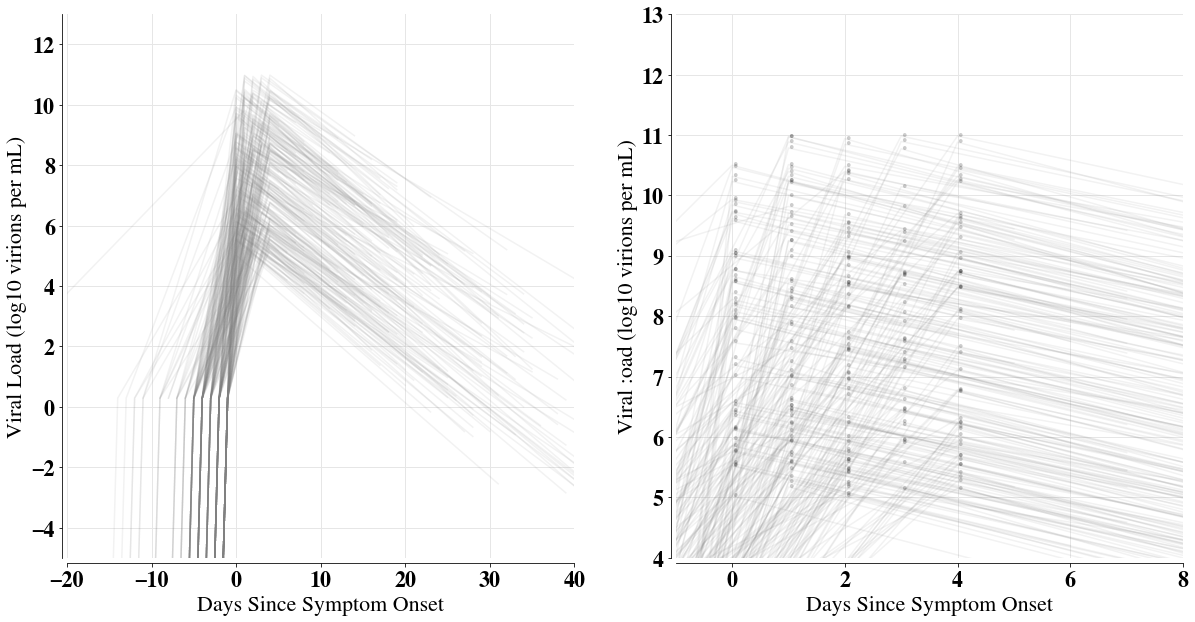

In [91]:
fig = plt.figure(figsize = (20, 10))
ax1 = fig.add_subplot(121)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.grid(axis='both', color="0.9", linestyle='-', linewidth=1)
ax1.get_xaxis().tick_bottom()
ax1.get_yaxis().tick_left()
ax1.tick_params(axis = 'x', direction = 'out')
ax1.tick_params(axis = 'y', direction = 'out')
# offset the spines
for spine in ax1.spines.values():
    spine.set_position(('outward', 5))
# put the grid behind
ax1.set_axisbelow(True)

ax2 = fig.add_subplot(122)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.grid(axis='both', color="0.9", linestyle='-', linewidth=1)
ax2.get_xaxis().tick_bottom()
ax2.get_yaxis().tick_left()
ax2.tick_params(axis = 'x', direction = 'out')
ax2.tick_params(axis = 'y', direction = 'out')
# offset the spines
for spine in ax2.spines.values():
    spine.set_position(('outward', 5))
# put the grid behind
ax2.set_axisbelow(True)

viral_load = np.empty((250, 300))
viral_load[:] = np.nan
for i in tqdm(range(250)):
    age_temp = scenario_standard.rnd_age()
    gender_temp = scenario_standard.rnd_gender(age_temp)
    comorbidities_temp = scenario_standard.rnd_comorbidities(age_temp, gender_temp)
    ii1 = scenario_standard.infection_course(age_temp, gender_temp, comorbidities_temp)
    vv1 = ii1['viral_load']
    ss1 = ii1['states']
    
    if 'infected-s' in ss1:
        symptom_onset = np.where(np.array(ss1) == 'infected-s')[0][0]
        neg_infs = np.where(np.array(vv1) == -np.inf)[0]
        vv1 = np.array(vv1)
        vv1[neg_infs] = -10
    
        days = range(0, len(vv1) - int(symptom_onset))
        days = [*np.arange(-symptom_onset, 0, 1), *days]
    
        ax1.plot(days, vv1, c = 'grey', alpha = .1)
        ax2.plot(days, vv1, c = 'grey', alpha = .1)
        ymax = np.nanmax(vv1)
        xmax = np.where(vv1 == ymax)[0][0]
        ax2.annotate('.',
                       xy = (xmax - symptom_onset, ymax),
                       xytext = (xmax - symptom_onset, ymax),
                       alpha = 0.2)
    
        viral_load[i, (150 - int(symptom_onset)):(150 + len(vv1) - int(symptom_onset))] = vv1
    
ax1.set_xlabel('Days Since Symptom Onset')
ax1.set_ylabel('Viral Load (log10 virions per mL)')
ax2.set_xlabel('Days Since Symptom Onset')
ax2.set_ylabel('Viral :oad (log10 virions per mL)')
ax1.set_xlim([-20, 40])
ax1.set_ylim([-5, 13])
ax2.set_xlim([-1, 8])
ax2.set_ylim([4, 13])

#ax1.legend(loc = (.29, .4), ncol = 2, frameon = False);

#ax1.set_xlabel('Days Since Infection');
#ax1.set_ylabel('Viral Load (log10 virions per mL)');
#ax1.set_title('(A1) Initial Serological Testing', style = 'italic');
fig.savefig(os.path.join(fig_dir, 'figS8-viral-load.png'), dpi = 300, bbox_inches = 'tight')
fig.savefig(os.path.join(fig_dir, 'figS8-viral-load.pdf'), dpi = 300, bbox_inches = 'tight')

## Model Testing

In [109]:
mitigation_strategy_r = mitigation(testing_effectiveness, groups = 1, period = 7)

scenario_weekly = scenario_details(comorbidities_distribution = comorbidities_prevalence,
                                     prop_healthy = [0, 0, 0],
                                     spreader_prop = 0.293,
                                     cases_age_gender = covid_cases_age_gender,
                                     risk_death_distribution = (covid_deaths_age_gender,
                                                                covid_deaths_comorbidities),
                                     transmission_probability = np.nan,
                                     mitigation_strategy = mitigation_strategy_r.antigen_random,
                                     external_connectivity = 0.0,
                                     steps_per_day = 1)

In [110]:
# initialize the model
# 5000 = 59 x 59
# 1000 = 26 x 26

model = covid_transmission_model(N_t = 1000,
                                 N_i = 10,
                                 N_r = 0,
                                 width = 40,
                                 height = 40,
                                 scenario = scenario_weekly,
                                 mitigation_strategy = mitigation_strategy_r)

In [111]:
# run the model for n steps
for i in tqdm(range(201)):
    model.step()

In [154]:
mitigation_strategy_r.cost.running_total

8657515.0

In [112]:
# get the data collected by the model
agents_states = model.datacollector.get_agent_vars_dataframe().reset_index()

In [113]:
sird_counts = pd.DataFrame(columns = range(200), index = ['s', 'i-as', 'i-s', 'i', 'p', 'q', 'r', 'd'])

In [114]:
for i in range(201):
    sird_counts.loc['s', i] = agents_states.loc[agents_states.Step == i, 'state'].eq('susceptible').sum()
    sird_counts.loc['i-as', i] = agents_states.loc[agents_states.Step == i, 'state'].eq('infected-as').sum()
    sird_counts.loc['i-s', i] = agents_states.loc[agents_states.Step == i, 'state'].eq('infected-s').sum()
    sird_counts.loc['i', i] = agents_states.loc[agents_states.Step == i, 'state'].eq('infected-as').sum() + agents_states.loc[agents_states.Step == i, 'state'].eq('infected-s').sum()
    sird_counts.loc['p', i] = agents_states.loc[agents_states.Step == i, 'state'].eq('positive').sum()
    sird_counts.loc['h', i] = agents_states.loc[agents_states.Step == i, 'state'].eq('hospitalized').sum()
    sird_counts.loc['q', i] = agents_states.loc[agents_states.Step == i, 'state'].eq('quarantined').sum()
    sird_counts.loc['r', i] = agents_states.loc[agents_states.Step == i, 'state'].eq('recovered').sum()
    sird_counts.loc['d', i] = agents_states.loc[agents_states.Step == i, 'state'].eq('dead').sum()
    
sird_counts /= 10

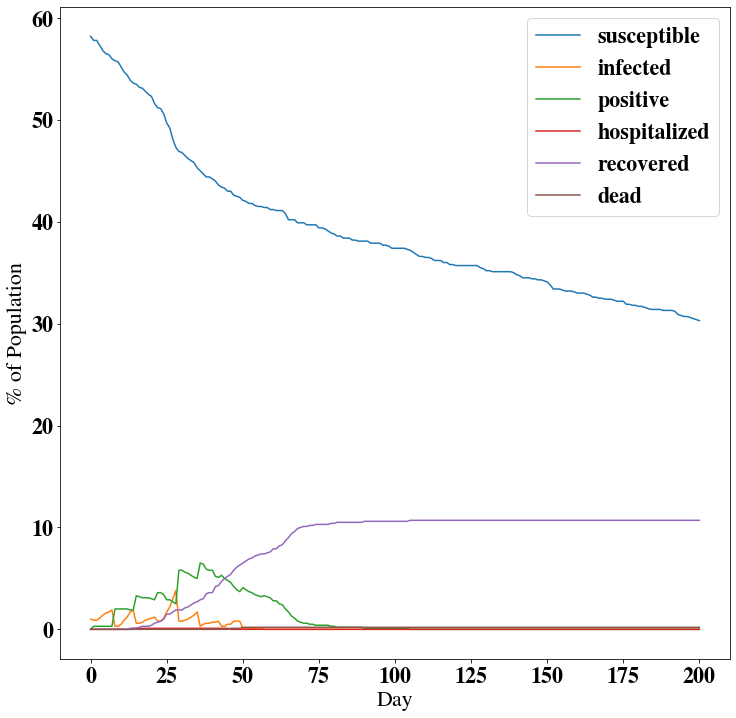

In [115]:
# look at the sird curve (should add "E" at some point)
plt.plot(sird_counts.loc['s', :].T, label = 'susceptible');
#plt.plot(sird_counts.loc['e', :].T, label = 'exposed');
plt.plot(sird_counts.loc['i', :].T, label = 'infected');
#plt.plot(sird_counts.loc['i-as', :].T, label = 'infected-as');
#plt.plot(sird_counts.loc['i-s', :].T, label = 'infected-s');
plt.plot(sird_counts.loc['p', :].T, label = 'positive');
plt.plot(sird_counts.loc['h', :].T, label = 'hospitalized');
#plt.plot(sird_counts.loc['q', :].T, label = 'quarantined');
plt.plot(sird_counts.loc['r', :].T, label = 'recovered');
plt.plot(sird_counts.loc['d', :].T, label = 'dead');
plt.legend();
plt.xlabel('Day');
plt.ylabel('% of Population');

In [159]:
sird_counts.iloc[:, -1]

s        9.5
i-as     0.0
i-s      0.0
i        0.0
p        0.0
q        0.0
r       88.6
d        1.9
h        0.0
Name: 200, dtype: float64

## No Mitigation

In [70]:
# Current CFR from COVID from CDC data
CFR = covid_deaths_age_gender['covid_19_deaths'].astype(int).sum() / (covid_cases_age_gender.sum().sum())
print(CFR)
# want percentage of deaths after simulation to equal CFR
# test how accurate that is...

0.020635149418660514


In [100]:
replicates = 200
max_steps = 201

N_t = 5000
#N_t = 1000
N_i = 50
#N_i = 10
N_r = 0
#N_r = 465 # assuming 9.3% seroprevalence from lancet paper

width = 140
#width = 119
height = 140
#height = 119
#scenario = scenario_standard

# R0 = 2.5 = 119*119
# R0 = 2 = 130 * 128
# R0 = 1.5 = 138 * 139

n_cores = 20

In [101]:
states, costs = MultiProcessorRunCustom(replicates,
                                 max_steps,
                                 N_t, N_i,
                                 N_r, width,
                                 height,
                                 scenario_standard,
                                 mitigation_strategy_b,
                                 n_cores)

In [102]:
sird_counts = np.ones((replicates, 7, max_steps))

for j in tqdm(range(replicates)):
    for i in range(max_steps):
        sird_counts[j, 0, i] = len(np.where(np.array([history[i] if len(history) > i else 'recovered' for history in states.state[j]])
                                               == 'susceptible')[0])
        sird_counts[j, 1, i] = len(np.where(np.array([history[i] if len(history) > i else 'recovered' for history in states.state[j]])
                                               == 'infected-as')[0])
        sird_counts[j, 2, i] = len(np.where(np.array([history[i] if len(history) > i else 'recovered' for history in states.state[j]])
                                               == 'infected-s')[0])
        sird_counts[j, 3, i] = len(np.where(np.array([history[i] if len(history) > i else 'recovered' for history in states.state[j]])
                                               == 'infected-as')[0]) + len(np.where(np.array([history[i] if len(history) > i else 'recovered' for history in states.state[j]])
                                               == 'infected-s')[0])
        sird_counts[j, 4, i] = len(np.where(np.array([history[i] if len(history) > i else 'recovered' for history in states.state[j]])
                                               == 'recovered')[0])
        sird_counts[j, 6, i] = len(np.where(np.array([history[i] if len(history) > i else 'recovered' for history in states.state[j]])
                                               == 'dead')[0])
        sird_counts[j, 5, i] = len(np.where(np.array([history[i] if len(history) > i else 'recovered' for history in states.state[j]])
                                               == 'hospitalized')[0])
        
#sird_counts[:, 4, :] = N_t - (sird_counts[:, 0, :] + sird_counts[:, 1, :] + sird_counts[:, 2, :] + sird_counts[:, 3, :] + sird_counts[:, 4, :] + sird_counts[:, 5, :])

sird_counts = sird_counts * 100 / N_t

In [103]:
with open(os.path.join(out_dir, '5000Agents-200Replicates-SIRD_counts-R0=1.5-India.pickle'), 'wb') as handle:
    pickle.dump(sird_counts, handle, protocol = pickle.HIGHEST_PROTOCOL)

In [ ]:
# sird_counts_list = list()
# for i in range(1, 11):
#     with open(os.path.join(out_dir,
#                            'NoMitigation/5000Agents-50Replicates-SIRD_counts-small-' + str(i) + '.pickle'),
#               'rb') as openfile:
#         sird_counts_list.append(pickle.load(openfile))
# sird_counts = np.concatenate(tuple(sird_counts_list))
# sird_counts = sird_counts[np.random.randint(low = 0, high = 500, size = 200), :, :]

In [122]:
with open(os.path.join(out_dir,
                           '5000Agents-200Replicates-SIRD_counts-India.pickle'),
              'rb') as openfile:
        sird_counts = pickle.load(openfile)

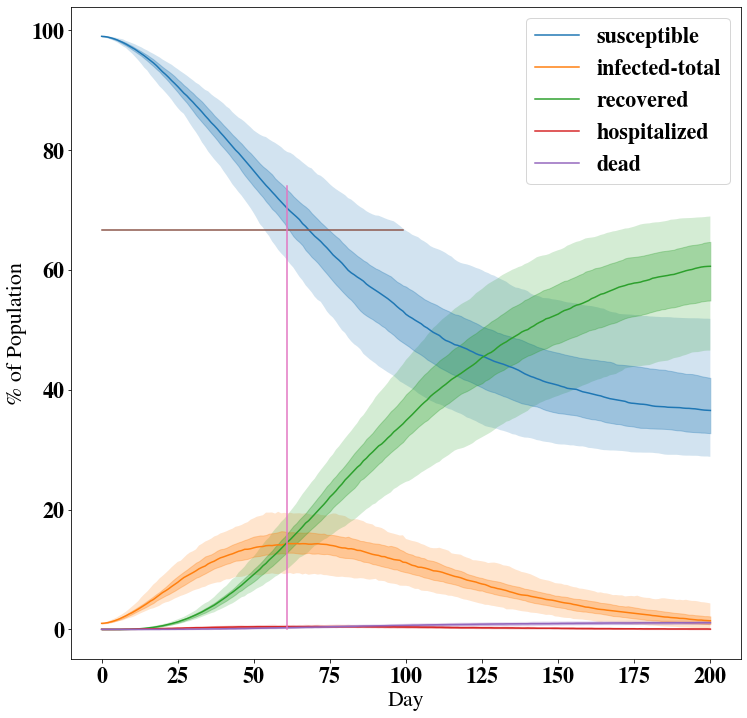

In [104]:
# look at the sird curve for multiple runs (should add "E" at some point)
plt.plot(np.median(sird_counts, axis = 0)[0], label = 'susceptible');
#plt.plot(sird_counts.loc['e', :].T, label = 'exposed');
#plt.plot(np.median(sird_counts, axis = 0)[1], label = 'infected-asymptomatic');
#plt.plot(np.median(sird_counts, axis = 0)[2], label = 'infected-symptomatic');
plt.plot(np.median(sird_counts, axis = 0)[3], label = 'infected-total');
plt.plot(np.median(sird_counts, axis = 0)[4], label = 'recovered');
plt.plot(np.median(sird_counts, axis = 0)[5], label = 'hospitalized');
plt.plot(np.median(sird_counts, axis = 0)[6], label = 'dead');
plt.fill_between(range(max_steps), np.percentile(sird_counts, axis = 0, q = 2.5)[0],
                 np.percentile(sird_counts, axis = 0, q = 97.5)[0], alpha = 0.2)
#plt.fill_between(range(max_steps), np.percentile(sird_counts, axis = 0, q = 2.5)[1],
#                 np.percentile(sird_counts, axis = 0, q = 97.5)[1], alpha = 0.2)
#plt.fill_between(range(max_steps), np.percentile(sird_counts, axis = 0, q = 2.5)[2],
#                 np.percentile(sird_counts, axis = 0, q = 97.5)[2], alpha = 0.2)
plt.fill_between(range(max_steps), np.percentile(sird_counts, axis = 0, q = 2.5)[3],
                 np.percentile(sird_counts, axis = 0, q = 97.5)[3], alpha = 0.2)
plt.fill_between(range(max_steps), np.percentile(sird_counts, axis = 0, q = 2.5)[4],
                 np.percentile(sird_counts, axis = 0, q = 97.5)[4], alpha = 0.2)
plt.fill_between(range(max_steps), np.percentile(sird_counts, axis = 0, q = 2.5)[5],
                 np.percentile(sird_counts, axis = 0, q = 97.5)[5], alpha = 0.2)
plt.fill_between(range(max_steps), np.percentile(sird_counts, axis = 0, q = 2.5)[6],
                 np.percentile(sird_counts, axis = 0, q = 97.5)[6], alpha = 0.2)


plt.fill_between(range(max_steps), np.percentile(sird_counts, axis = 0, q = 25)[0],
                 np.percentile(sird_counts, axis = 0, q = 75)[0], alpha = 0.3, color = "C{}".format(0))
#plt.fill_between(range(max_steps), np.percentile(sird_counts, axis = 0, q = 2.5)[1],
#                 np.percentile(sird_counts, axis = 0, q = 97.5)[1], alpha = 0.2)
#plt.fill_between(range(max_steps), np.percentile(sird_counts, axis = 0, q = 2.5)[2],
#                 np.percentile(sird_counts, axis = 0, q = 97.5)[2], alpha = 0.2)
plt.fill_between(range(max_steps), np.percentile(sird_counts, axis = 0, q = 25)[3],
                 np.percentile(sird_counts, axis = 0, q = 75)[3], alpha = 0.3, color = "C{}".format(1))
plt.fill_between(range(max_steps), np.percentile(sird_counts, axis = 0, q = 25)[4],
                 np.percentile(sird_counts, axis = 0, q = 75)[4], alpha = 0.3, color = "C{}".format(2))
plt.fill_between(range(max_steps), np.percentile(sird_counts, axis = 0, q = 25)[5],
                 np.percentile(sird_counts, axis = 0, q = 75)[5], alpha = 0.3, color = "C{}".format(3))
plt.fill_between(range(max_steps), np.percentile(sird_counts, axis = 0, q = 25)[6],
                 np.percentile(sird_counts, axis = 0, q = 75)[6], alpha = 0.3, color = "C{}".format(4))


plt.plot(range(100), np.repeat(100/1.5, 100))
plt.plot(np.repeat(np.where(np.median(sird_counts, axis = 0)[3] == np.max(np.median(sird_counts, axis = 0)[3]))[0][0],
                   75),
        range(75))

plt.legend();
plt.xlabel('Day');
plt.ylabel('% of Population');
#plt.savefig(os.path.join(fig_dir, 'NoMitigationReplicates-50th&95thPercentiles-5000Agents-200Replicates-India.png'))
#plt.savefig(os.path.join(fig_dir, 'NoMitigationReplicates-50th&95thPercentiles-5000Agents-200Replicates-India.pdf'))

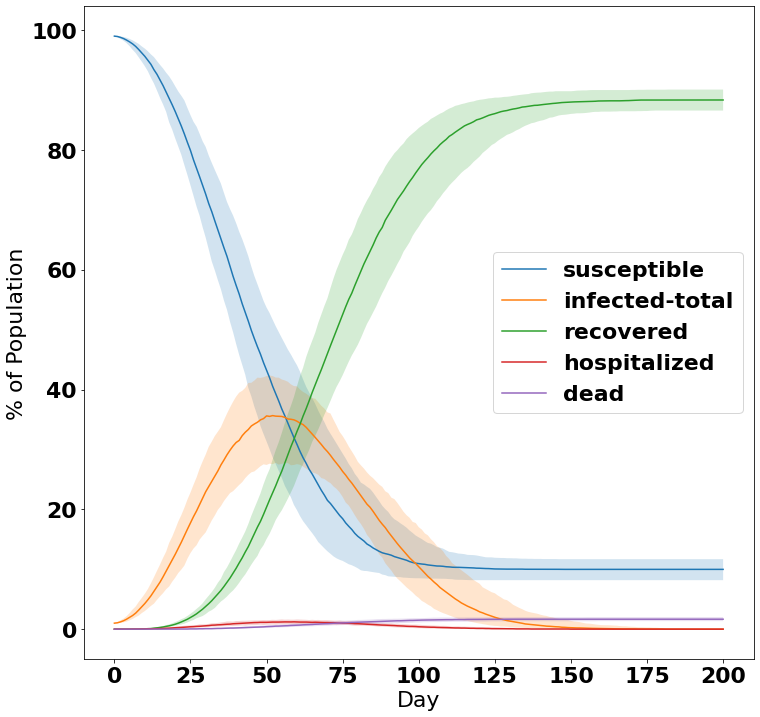

In [89]:
# look at the sird curve for multiple runs (should add "E" at some point)
plt.plot(np.median(sird_counts, axis = 0)[0], label = 'susceptible');
#plt.plot(sird_counts.loc['e', :].T, label = 'exposed');
#plt.plot(np.median(sird_counts, axis = 0)[1], label = 'infected-asymptomatic');
#plt.plot(np.median(sird_counts, axis = 0)[2], label = 'infected-symptomatic');
plt.plot(np.median(sird_counts, axis = 0)[3], label = 'infected-total');
plt.plot(np.median(sird_counts, axis = 0)[4], label = 'recovered');
plt.plot(np.median(sird_counts, axis = 0)[5], label = 'hospitalized');
plt.plot(np.median(sird_counts, axis = 0)[6], label = 'dead');
plt.fill_between(range(max_steps), np.percentile(sird_counts, axis = 0, q = 2.5)[0],
                 np.percentile(sird_counts, axis = 0, q = 97.5)[0], alpha = 0.2)
#plt.fill_between(range(max_steps), np.percentile(sird_counts, axis = 0, q = 2.5)[1],
#                 np.percentile(sird_counts, axis = 0, q = 97.5)[1], alpha = 0.2)
#plt.fill_between(range(max_steps), np.percentile(sird_counts, axis = 0, q = 2.5)[2],
#                 np.percentile(sird_counts, axis = 0, q = 97.5)[2], alpha = 0.2)
plt.fill_between(range(max_steps), np.percentile(sird_counts, axis = 0, q = 2.5)[3],
                 np.percentile(sird_counts, axis = 0, q = 97.5)[3], alpha = 0.2)
plt.fill_between(range(max_steps), np.percentile(sird_counts, axis = 0, q = 2.5)[4],
                 np.percentile(sird_counts, axis = 0, q = 97.5)[4], alpha = 0.2)
plt.fill_between(range(max_steps), np.percentile(sird_counts, axis = 0, q = 2.5)[5],
                 np.percentile(sird_counts, axis = 0, q = 97.5)[5], alpha = 0.2)
plt.fill_between(range(max_steps), np.percentile(sird_counts, axis = 0, q = 2.5)[6],
                 np.percentile(sird_counts, axis = 0, q = 97.5)[6], alpha = 0.2)

plt.legend();
plt.xlabel('Day');
plt.ylabel('% of Population');
plt.savefig(os.path.join(fig_dir, 'NoMitigationReplicates-95thPercentiles-5000Agents-200Replicates-India.png'))
plt.savefig(os.path.join(fig_dir, 'NoMitigationReplicates-95thPercentiles-5000Agents-200Replicates-India.pdf'))

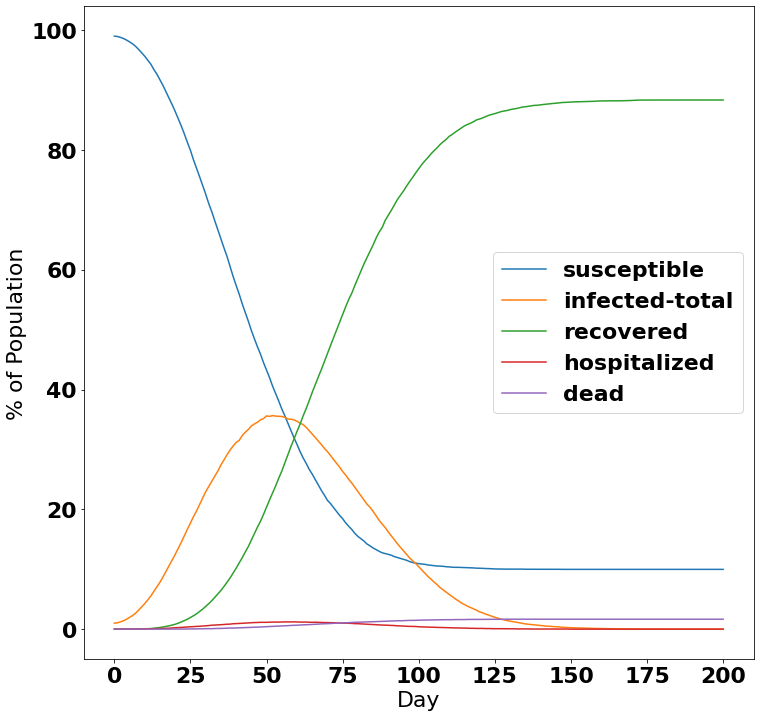

In [90]:
# look at the sird curve for multiple runs (should add "E" at some point)
plt.plot(np.median(sird_counts, axis = 0)[0], label = 'susceptible');
#plt.plot(sird_counts.loc['e', :].T, label = 'exposed');
#plt.plot(np.median(sird_counts, axis = 0)[1], label = 'infected-asymptomatic');
#plt.plot(np.median(sird_counts, axis = 0)[2], label = 'infected-symptomatic');
plt.plot(np.median(sird_counts, axis = 0)[3], label = 'infected-total');
plt.plot(np.median(sird_counts, axis = 0)[4], label = 'recovered');
plt.plot(np.median(sird_counts, axis = 0)[5], label = 'hospitalized');
plt.plot(np.median(sird_counts, axis = 0)[6], label = 'dead');
#plt.fill_between(range(max_steps), np.percentile(sird_counts, axis = 0, q = 2.5)[0],
#                 np.percentile(sird_counts, axis = 0, q = 97.5)[0], alpha = 0.2)
#plt.fill_between(range(max_steps), np.percentile(sird_counts, axis = 0, q = 2.5)[1],
#                 np.percentile(sird_counts, axis = 0, q = 97.5)[1], alpha = 0.2)
#plt.fill_between(range(max_steps), np.percentile(sird_counts, axis = 0, q = 2.5)[2],
#                 np.percentile(sird_counts, axis = 0, q = 97.5)[2], alpha = 0.2)
#plt.fill_between(range(max_steps), np.percentile(sird_counts, axis = 0, q = 2.5)[3],
#                 np.percentile(sird_counts, axis = 0, q = 97.5)[3], alpha = 0.2)
#plt.fill_between(range(max_steps), np.percentile(sird_counts, axis = 0, q = 2.5)[4],
#                 np.percentile(sird_counts, axis = 0, q = 97.5)[4], alpha = 0.2)
#plt.fill_between(range(max_steps), np.percentile(sird_counts, axis = 0, q = 2.5)[5],
#                 np.percentile(sird_counts, axis = 0, q = 97.5)[5], alpha = 0.2)
#plt.fill_between(range(max_steps), np.percentile(sird_counts, axis = 0, q = 2.5)[6],
#                 np.percentile(sird_counts, axis = 0, q = 97.5)[6], alpha = 0.2)
plt.legend();
plt.xlabel('Day');
plt.ylabel('% of Population');
plt.savefig(os.path.join(fig_dir, 'NoMitigationReplicates-5000Agents-200Replicates-Median-India.png'))
plt.savefig(os.path.join(fig_dir, 'NoMitigationReplicates-5000Agents-200Replicates-Median-India.pdf'))

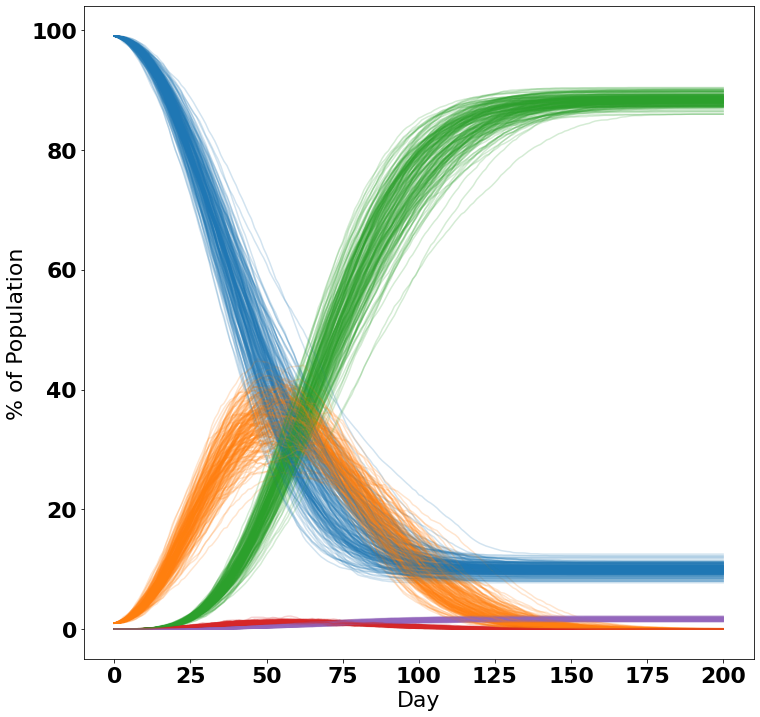

In [124]:
for i in range(replicates):
    plt.plot(sird_counts[i, 0, :].T, c = "C{}".format(0), alpha = .2)
    plt.plot(sird_counts[i, 3, :].T, c = "C{}".format(1), alpha = .2)
    plt.plot(sird_counts[i, 4, :].T, c = "C{}".format(2), alpha = .2)
    plt.plot(sird_counts[i, 5, :].T, c = "C{}".format(3), alpha = .2)
    plt.plot(sird_counts[i, 6, :].T, c = "C{}".format(4), alpha = .2)

plt.ylabel('% of Population');
plt.xlabel('Day');
plt.savefig(os.path.join(fig_dir, 'NoMitigation-IndividualRuns-5000Agents-200Replicates-India.png'))
plt.savefig(os.path.join(fig_dir, 'NoMitigation-IndividualRuns-5000Agents-200Replicates-India.pdf'))

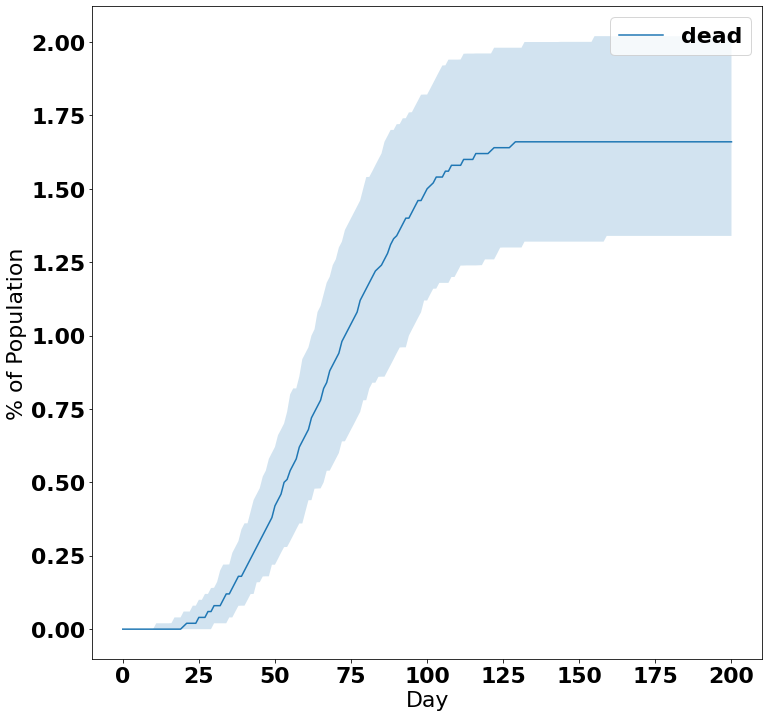

In [92]:
# look at the sird curve for multiple runs (should add "E" at some point)
plt.plot(np.median(sird_counts, axis = 0)[6], label = 'dead');
plt.fill_between(range(max_steps), np.percentile(sird_counts, axis = 0, q = 2.5)[6],
                 np.percentile(sird_counts, axis = 0, q = 97.5)[6], alpha = 0.2)
plt.legend();
plt.xlabel('Day');
plt.ylabel('% of Population');
#plt.savefig(os.path.join(fig_dir, 'SIRD-Curve-100Replicates.png'))

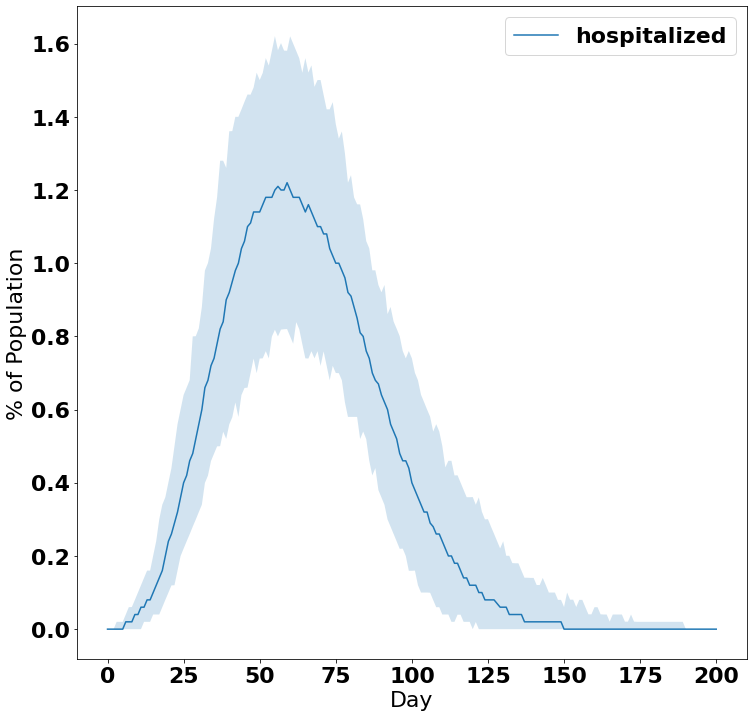

In [93]:
# look at the sird curve for multiple runs (should add "E" at some point)
plt.plot(np.median(sird_counts, axis = 0)[5], label = 'hospitalized');
plt.fill_between(range(max_steps), np.percentile(sird_counts, axis = 0, q = 2.5)[5],
                 np.percentile(sird_counts, axis = 0, q = 97.5)[5], alpha = 0.2)
plt.legend();
plt.xlabel('Day');
plt.ylabel('% of Population');
#plt.savefig(os.path.join(fig_dir, 'SIRD-Curve-100Replicates.png'))

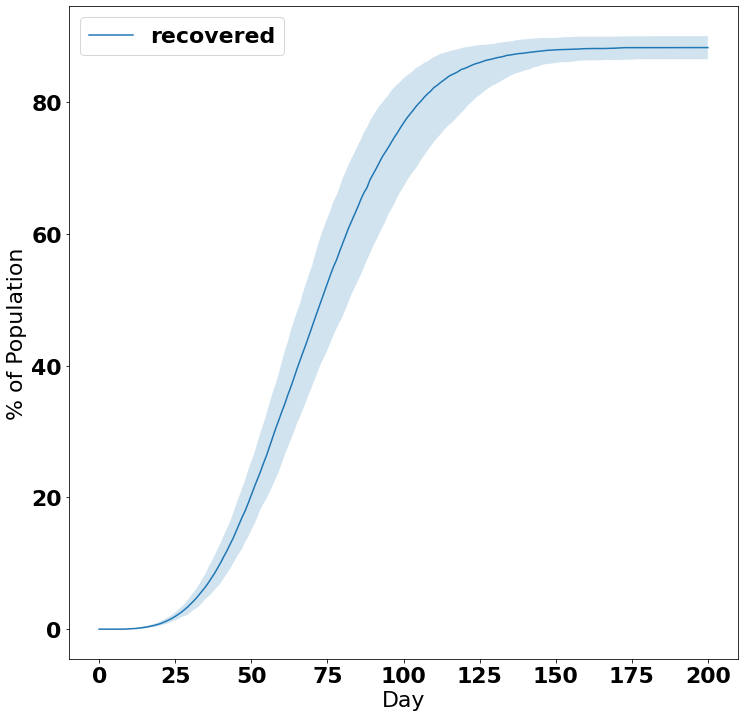

In [94]:
plt.plot(np.median(sird_counts, axis = 0)[4], label = 'recovered');

plt.fill_between(range(max_steps), np.percentile(sird_counts, axis = 0, q = 2.5)[4],
                 np.percentile(sird_counts, axis = 0, q = 97.5)[4], alpha = 0.2)
plt.legend();
plt.xlabel('Day');
plt.ylabel('% of Population');
#plt.savefig(os.path.join(fig_dir, 'SIRD-Curve-100Replicates.png'))

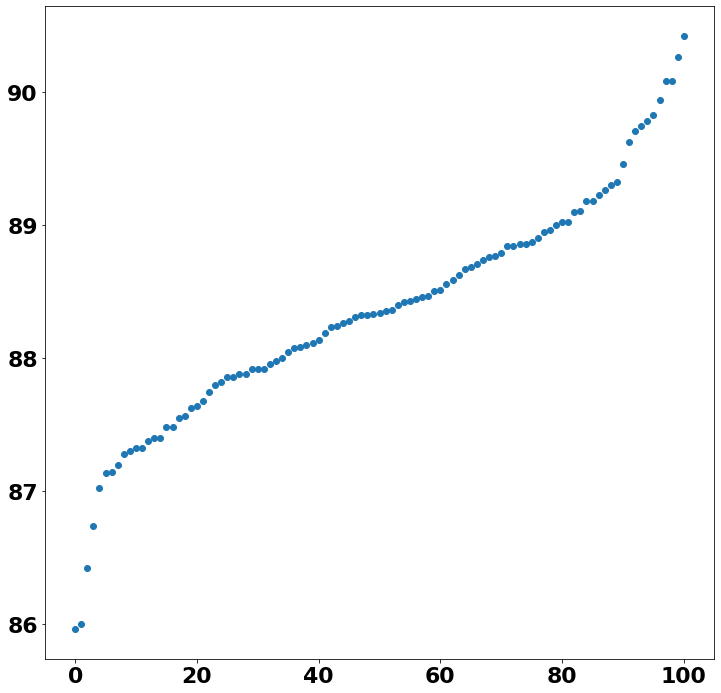

In [95]:
plt.scatter(range(101),
            [np.percentile(sird_counts, axis = 0, q = i)[4][-1] for i in range(101)]);

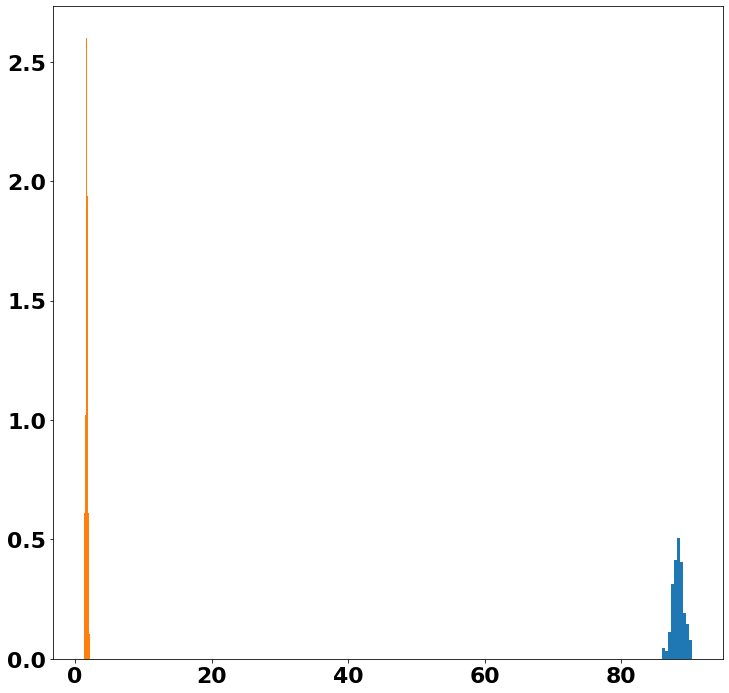

In [96]:
#plt.hist(sird_counts[:, 0, -1], density = True)
#plt.hist(sird_counts[:, 3, -1], density = True)
plt.hist(sird_counts[:, 4, -1], density = True);
plt.hist(sird_counts[:, 6, -1], density = True);

In [97]:
print(np.median(sird_counts[:, 4, -1]))
print(np.median(sird_counts[:, 5, -1]))
print(np.median(sird_counts[:, 6, -1]))

88.34
0.0
1.66


In [98]:
np.nanmean(100 * sird_counts[:, 6, -1] / (sird_counts[:, 4, -1] - sird_counts[:, 6, -1]))

1.9391972058720142

In [99]:
np.nanmedian(100 * sird_counts[:, 6, -1] / (sird_counts[:, 4, -1] - sird_counts[:, 6, -1]))

1.9252823883562686

In [100]:
np.nanstd(100 * sird_counts[:, 6, -1] / (sird_counts[:, 4, -1] - sird_counts[:, 6, -1]))

0.20848989668263693

In [101]:
np.nanpercentile(100 * sird_counts[:, 6, -1] / (sird_counts[:, 4, -1] - sird_counts[:, 6, -1]), 2.5)

1.5099756193749274

In [102]:
np.nanpercentile(100 * sird_counts[:, 6, -1] / (sird_counts[:, 4, -1] - sird_counts[:, 6, -1]), 97.5)

2.3466870347802704

## Scenarios in Focus: Specific Testing Frequencies/Number of People

In [132]:
mitigation_strategy_r = mitigation(testing_effectiveness, groups = 1, period = 7)

scenario_weekly = scenario_details(comorbidities_distribution = comorbidities_prevalence,
                                     prop_healthy = [0, 0, 0],
                                     spreader_prop = 0.293,
                                     cases_age_gender = covid_cases_age_gender,
                                     risk_death_distribution = (covid_deaths_age_gender,
                                                                covid_deaths_comorbidities),
                                     transmission_probability = np.nan,
                                     mitigation_strategy = mitigation_strategy_r.antigen_random,
                                     external_connectivity = 0.0,
                                     steps_per_day = 1)

In [134]:
replicates = 200
max_steps = 201

N_t = 5000
N_i = 50
N_r = 465

#width = 119
#height = 119
#width = 139
#height = 138
scenario = scenario_weekly

n_cores = 14

In [135]:
states, costs = MultiProcessorRunCustom(replicates, max_steps, N_t, N_i, N_r, width, height, scenario,
                                 mitigation_strategy_r, n_cores)

In [136]:
sird_counts = np.ones((replicates, 9, max_steps))

for j in tqdm(range(replicates)):
    for i in range(max_steps):
        sird_counts[j, 0, i] = len(np.where(np.array([history[i] if len(history) > i else 'recovered' for history in states.state[j]])
                                               == 'susceptible')[0])
        sird_counts[j, 1, i] = len(np.where(np.array([history[i] if len(history) > i else 'recovered' for history in states.state[j]])
                                               == 'infected-as')[0])
        sird_counts[j, 2, i] = len(np.where(np.array([history[i] if len(history) > i else 'recovered' for history in states.state[j]])
                                               == 'infected-s')[0])
        sird_counts[j, 3, i] = len(np.where(np.array([history[i] if len(history) > i else 'recovered' for history in states.state[j]])
                                               == 'infected-as')[0]) + len(np.where(np.array([history[i] if len(history) > i else 'recovered' for history in states.state[j]])
                                               == 'infected-s')[0])
        sird_counts[j, 4, i] = len(np.where(np.array([history[i] if len(history) > i else 'recovered' for history in states.state[j]])
                                               == 'positive')[0])
        sird_counts[j, 5, i] = len(np.where(np.array([history[i] if len(history) > i else 'recovered' for history in states.state[j]])
                                               == 'recovered')[0])
        sird_counts[j, 6, i] = len(np.where(np.array([history[i] if len(history) > i else 'recovered' for history in states.state[j]])
                                               == 'dead')[0])
        sird_counts[j, 7, i] = len(np.where(np.array([history[i] if len(history) > i else 'recovered' for history in states.state[j]])
                                               == 'hospitalized')[0])
        sird_counts[j, 8, i] = len(np.where(np.array([history[i] if len(history) > i else 'recovered' for history in states.state[j]])
                                               == 'vaccinated')[0])
        
#sird_counts[:, 5, :] = N_t - (sird_counts[:, 0, :] + sird_counts[:, 1, :] + sird_counts[:, 2, :] + sird_counts[:, 3, :] + sird_counts[:, 4, :] + sird_counts[:, 6, :] + sird_counts[:, 7, :])

sird_counts = sird_counts * 100 / N_t

In [137]:
with open(os.path.join(out_dir, '5000Agents-200Replicates-SIRD_counts-WeeklyWholePopRT-PCR-R0=2.5-India20%VaccinatedWith75%Effectivity.pickle'), 'wb') as handle:
    pickle.dump((sird_counts, costs), handle, protocol = pickle.HIGHEST_PROTOCOL)

In [138]:
mitigation_strategy_r = mitigation(testing_effectiveness, groups = 3, period = 7)

scenario_weekly = scenario_details(comorbidities_distribution = comorbidities_prevalence,
                                     prop_healthy = [0, 0, 0],
                                     spreader_prop = 0.293,
                                     cases_age_gender = covid_cases_age_gender,
                                     risk_death_distribution = (covid_deaths_age_gender,
                                                                covid_deaths_comorbidities),
                                     transmission_probability = np.nan,
                                     mitigation_strategy = mitigation_strategy_r.antigen_random,
                                     external_connectivity = 0.0,
                                     steps_per_day = 1)

In [139]:
replicates = 200
max_steps = 201

N_t = 5000
N_i = 50
N_r = 465

width = 119
height = 119
#width = 138
#height = 139
scenario = scenario_weekly

n_cores = 12

In [140]:
states, costs = MultiProcessorRunCustom(replicates, max_steps, N_t, N_i, N_r, width, height, scenario,
                                 mitigation_strategy_r, n_cores)

In [141]:
sird_counts = np.ones((replicates, 9, max_steps))

for j in tqdm(range(replicates)):
    for i in range(max_steps):
        sird_counts[j, 0, i] = len(np.where(np.array([history[i] if len(history) > i else 'recovered' for history in states.state[j]])
                                               == 'susceptible')[0])
        sird_counts[j, 1, i] = len(np.where(np.array([history[i] if len(history) > i else 'recovered' for history in states.state[j]])
                                               == 'infected-as')[0])
        sird_counts[j, 2, i] = len(np.where(np.array([history[i] if len(history) > i else 'recovered' for history in states.state[j]])
                                               == 'infected-s')[0])
        sird_counts[j, 3, i] = len(np.where(np.array([history[i] if len(history) > i else 'recovered' for history in states.state[j]])
                                               == 'infected-as')[0]) + len(np.where(np.array([history[i] if len(history) > i else 'recovered' for history in states.state[j]])
                                               == 'infected-s')[0])
        sird_counts[j, 4, i] = len(np.where(np.array([history[i] if len(history) > i else 'recovered' for history in states.state[j]])
                                               == 'positive')[0])
        sird_counts[j, 5, i] = len(np.where(np.array([history[i] if len(history) > i else 'recovered' for history in states.state[j]])
                                               == 'recovered')[0])
        sird_counts[j, 6, i] = len(np.where(np.array([history[i] if len(history) > i else 'recovered' for history in states.state[j]])
                                               == 'dead')[0])
        sird_counts[j, 7, i] = len(np.where(np.array([history[i] if len(history) > i else 'recovered' for history in states.state[j]])
                                               == 'hospitalized')[0])
        sird_counts[j, 8, i] = len(np.where(np.array([history[i] if len(history) > i else 'recovered' for history in states.state[j]])
                                               == 'vaccinated')[0])
        
#sird_counts[:, 5, :] = N_t - (sird_counts[:, 0, :] + sird_counts[:, 1, :] + sird_counts[:, 2, :] + sird_counts[:, 3, :] + sird_counts[:, 4, :] + sird_counts[:, 6, :] + sird_counts[:, 7, :])

sird_counts = sird_counts * 100 / N_t

In [142]:
with open(os.path.join(out_dir, '5000Agents-200Replicates-SIRD_counts-TriWeeklyWholePopAntigen-R0=2.5-India20%VaccinatedWith75%Effectivity.pickle'), 'wb') as handle:
    pickle.dump((sird_counts, costs), handle, protocol = pickle.HIGHEST_PROTOCOL)

In [80]:
mitigation_strategy_r = mitigation(testing_effectiveness, groups = 1, period = 7)

scenario_weekly = scenario_details(comorbidities_distribution = comorbidities_prevalence,
                                     prop_healthy = [0, 0, 0],
                                     spreader_prop = 0.293,
                                     cases_age_gender = covid_cases_age_gender,
                                     risk_death_distribution = (covid_deaths_age_gender,
                                                                covid_deaths_comorbidities),
                                     transmission_probability = np.nan,
                                     mitigation_strategy = mitigation_strategy_r.antigen_random,
                                     external_connectivity = 0.0,
                                     steps_per_day = 1)

In [81]:
replicates = 200
max_steps = 201

N_t = 5000
N_i = 50
N_r = 0

#width = 119
#height = 119
width = 138
height = 139
scenario = scenario_weekly

n_cores = 20

In [82]:
states, costs = MultiProcessorRunCustom(replicates, max_steps, N_t, N_i, N_r, width, height, scenario,
                                 mitigation_strategy_r, n_cores)

In [83]:
sird_counts = np.ones((replicates, 8, max_steps))

for j in tqdm(range(replicates)):
    for i in range(max_steps):
        sird_counts[j, 0, i] = len(np.where(np.array([history[i] if len(history) > i else 'recovered' for history in states.state[j]])
                                               == 'susceptible')[0])
        sird_counts[j, 1, i] = len(np.where(np.array([history[i] if len(history) > i else 'recovered' for history in states.state[j]])
                                               == 'infected-as')[0])
        sird_counts[j, 2, i] = len(np.where(np.array([history[i] if len(history) > i else 'recovered' for history in states.state[j]])
                                               == 'infected-s')[0])
        sird_counts[j, 3, i] = len(np.where(np.array([history[i] if len(history) > i else 'recovered' for history in states.state[j]])
                                               == 'infected-as')[0]) + len(np.where(np.array([history[i] if len(history) > i else 'recovered' for history in states.state[j]])
                                               == 'infected-s')[0])
        sird_counts[j, 4, i] = len(np.where(np.array([history[i] if len(history) > i else 'recovered' for history in states.state[j]])
                                               == 'positive')[0])
        sird_counts[j, 5, i] = len(np.where(np.array([history[i] if len(history) > i else 'recovered' for history in states.state[j]])
                                               == 'recovered')[0])
        sird_counts[j, 6, i] = len(np.where(np.array([history[i] if len(history) > i else 'recovered' for history in states.state[j]])
                                               == 'dead')[0])
        sird_counts[j, 7, i] = len(np.where(np.array([history[i] if len(history) > i else 'recovered' for history in states.state[j]])
                                               == 'hospitalized')[0])
        
#sird_counts[:, 5, :] = N_t - (sird_counts[:, 0, :] + sird_counts[:, 1, :] + sird_counts[:, 2, :] + sird_counts[:, 3, :] + sird_counts[:, 4, :] + sird_counts[:, 6, :] + sird_counts[:, 7, :])

sird_counts = sird_counts * 100 / N_t

In [84]:
with open(os.path.join(out_dir, '5000Agents-200Replicates-SIRD_counts-WeeklyWholePopAntigen-R0=1.5-India.pickle'), 'wb') as handle:
    pickle.dump((sird_counts, costs), handle, protocol = pickle.HIGHEST_PROTOCOL)

In [85]:
mitigation_strategy_r = mitigation(testing_effectiveness, groups = 3, period = 7)

scenario_weekly = scenario_details(comorbidities_distribution = comorbidities_prevalence,
                                     prop_healthy = [0, 0, 0],
                                     spreader_prop = 0.293,
                                     cases_age_gender = covid_cases_age_gender,
                                     risk_death_distribution = (covid_deaths_age_gender,
                                                                covid_deaths_comorbidities),
                                     transmission_probability = np.nan,
                                     mitigation_strategy = mitigation_strategy_r.antigen_random,
                                     external_connectivity = 0.0,
                                     steps_per_day = 1)

In [86]:
replicates = 200
max_steps = 201

N_t = 5000
N_i = 50
N_r = 0

#width = 119
#height = 119
width = 138
height = 139
scenario = scenario_weekly

n_cores = 20

In [87]:
states, costs = MultiProcessorRunCustom(replicates, max_steps, N_t, N_i, N_r, width, height, scenario,
                                 mitigation_strategy_r, n_cores)

In [88]:
sird_counts = np.ones((replicates, 8, max_steps))

for j in tqdm(range(replicates)):
    for i in range(max_steps):
        sird_counts[j, 0, i] = len(np.where(np.array([history[i] if len(history) > i else 'recovered' for history in states.state[j]])
                                               == 'susceptible')[0])
        sird_counts[j, 1, i] = len(np.where(np.array([history[i] if len(history) > i else 'recovered' for history in states.state[j]])
                                               == 'infected-as')[0])
        sird_counts[j, 2, i] = len(np.where(np.array([history[i] if len(history) > i else 'recovered' for history in states.state[j]])
                                               == 'infected-s')[0])
        sird_counts[j, 3, i] = len(np.where(np.array([history[i] if len(history) > i else 'recovered' for history in states.state[j]])
                                               == 'infected-as')[0]) + len(np.where(np.array([history[i] if len(history) > i else 'recovered' for history in states.state[j]])
                                               == 'infected-s')[0])
        sird_counts[j, 4, i] = len(np.where(np.array([history[i] if len(history) > i else 'recovered' for history in states.state[j]])
                                               == 'positive')[0])
        sird_counts[j, 5, i] = len(np.where(np.array([history[i] if len(history) > i else 'recovered' for history in states.state[j]])
                                               == 'recovered')[0])
        sird_counts[j, 6, i] = len(np.where(np.array([history[i] if len(history) > i else 'recovered' for history in states.state[j]])
                                               == 'dead')[0])
        sird_counts[j, 7, i] = len(np.where(np.array([history[i] if len(history) > i else 'recovered' for history in states.state[j]])
                                               == 'hospitalized')[0])
        
#sird_counts[:, 5, :] = N_t - (sird_counts[:, 0, :] + sird_counts[:, 1, :] + sird_counts[:, 2, :] + sird_counts[:, 3, :] + sird_counts[:, 4, :] + sird_counts[:, 6, :] + sird_counts[:, 7, :])

sird_counts = sird_counts * 100 / N_t

In [89]:
with open(os.path.join(out_dir, '5000Agents-200Replicates-SIRD_counts-TriWeeklyWholePopAntigen-R0=1.5-India.pickle'), 'wb') as handle:
    pickle.dump((sird_counts, costs), handle, protocol = pickle.HIGHEST_PROTOCOL)

'NimbusRoman-Bold.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'NimbusRoman-Regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


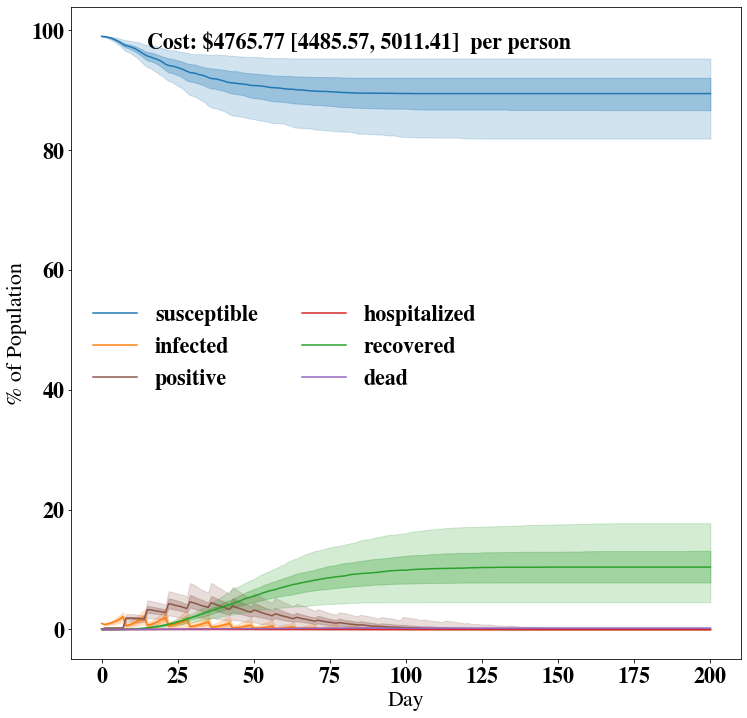

In [89]:
# look at the sird curve for multiple runs (should add "E" at some point)
plt.plot(np.median(sird_counts, axis = 0)[0], label = 'susceptible', color = "C{}".format(0));
plt.plot((np.median(sird_counts, axis = 0)[3]), label = 'infected', color = "C{}".format(1));
plt.plot(np.median(sird_counts, axis = 0)[4], label = 'positive', color = "C{}".format(5));
plt.plot(np.median(sird_counts, axis = 0)[7], label = 'hospitalized', color = "C{}".format(3));
plt.plot(np.median(sird_counts, axis = 0)[5], label = 'recovered', color = "C{}".format(2));
plt.plot(np.median(sird_counts, axis = 0)[6], label = 'dead', color ="C{}".format(4));

plt.fill_between(range(max_steps), np.percentile(sird_counts, axis = 0, q = 25)[0],
                 np.percentile(sird_counts, axis = 0, q = 75)[0], alpha = 0.3, color = "C{}".format(0))
plt.fill_between(range(max_steps), (np.percentile(sird_counts, axis = 0, q = 25)[3]),
                 (np.percentile(sird_counts, axis = 0, q = 75)[3]), alpha = 0.3, color = "C{}".format(1))
plt.fill_between(range(max_steps), np.percentile(sird_counts, axis = 0, q = 25)[4],
                 np.percentile(sird_counts, axis = 0, q = 75)[4], alpha = 0.3, color = "C{}".format(5))
plt.fill_between(range(max_steps), np.percentile(sird_counts, axis = 0, q = 25)[5],
                 np.percentile(sird_counts, axis = 0, q = 75)[5], alpha = 0.3, color = "C{}".format(2))
plt.fill_between(range(max_steps), np.percentile(sird_counts, axis = 0, q = 25)[6],
                 np.percentile(sird_counts, axis = 0, q = 75)[6], alpha = 0.3, color = "C{}".format(4))
plt.fill_between(range(max_steps), np.percentile(sird_counts, axis = 0, q = 25)[7],
                 np.percentile(sird_counts, axis = 0, q = 75)[7], alpha = 0.3, color = "C{}".format(3))

plt.fill_between(range(max_steps), np.percentile(sird_counts, axis = 0, q = 2.5)[0],
                 np.percentile(sird_counts, axis = 0, q = 97.5)[0], alpha = 0.2, color = "C{}".format(0))
plt.fill_between(range(max_steps), (np.percentile(sird_counts, axis = 0, q = 2.5)[3]),
                 (np.percentile(sird_counts, axis = 0, q = 97.5)[3]), alpha = 0.2, color = "C{}".format(1))
plt.fill_between(range(max_steps), np.percentile(sird_counts, axis = 0, q = 2.5)[4],
                 np.percentile(sird_counts, axis = 0, q = 97.5)[4], alpha = 0.2, color = "C{}".format(5))
plt.fill_between(range(max_steps), np.percentile(sird_counts, axis = 0, q = 2.5)[5],
                 np.percentile(sird_counts, axis = 0, q = 97.5)[5], alpha = 0.2, color = "C{}".format(2))
plt.fill_between(range(max_steps), np.percentile(sird_counts, axis = 0, q = 2.5)[6],
                 np.percentile(sird_counts, axis = 0, q = 97.5)[6], alpha = 0.2, color = "C{}".format(4))
plt.fill_between(range(max_steps), np.percentile(sird_counts, axis = 0, q = 2.5)[7],
                 np.percentile(sird_counts, axis = 0, q = 97.5)[7], alpha = 0.2, color = "C{}".format(3))

plt.text(15, 97, 'Cost: $' + str(round(np.median(costs) / 5000, 2)) + ' [' + str(round(np.percentile(costs, 2.5) / 5000, 2)) + ', ' + str(round(np.percentile(costs, 97.5) / 5000, 2)) + '] ' + ' per person')
#plt.ylim([0, 100])
plt.legend(loc = (.02, .4), ncol = 2, frameon = False);
plt.xlabel('Day');
plt.ylabel('% of Population');
plt.savefig(os.path.join(fig_dir, 'WeeklyWholePopulationRT-PCR-Immediate-Testing-India.png'))
plt.savefig(os.path.join(fig_dir, 'WeeklyWholePopulationRT-PCR-Immediate-Testing-India.pdf'))

In [ ]:
np.where(np.median(sird_counts[:, 3, :], axis = 0) < 5)

In [ ]:
plt.plot(np.where(np.median(sird_counts[:, 3, :] + sird_counts[:, 4, :], axis = 0) < 2)[0])

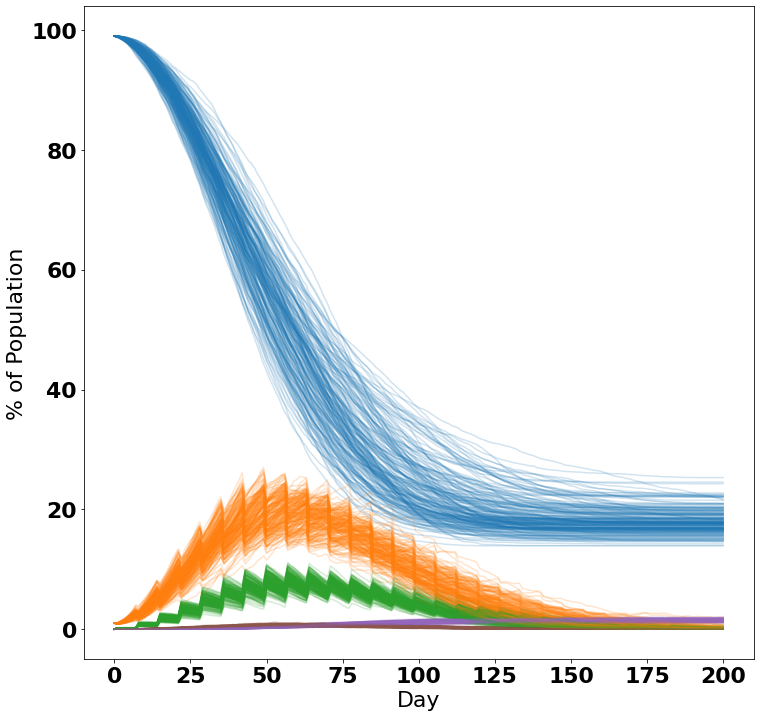

In [93]:
for i in range(replicates):
    plt.plot(sird_counts[i, 0, :].T, c = "C{}".format(0), alpha = .2)
    plt.plot(sird_counts[i, 3, :].T, c = "C{}".format(1), alpha = .2)
    plt.plot(sird_counts[i, 4, :].T, c = "C{}".format(2), alpha = .2)
    plt.plot(sird_counts[i, 6, :].T, c = "C{}".format(4), alpha = .2)
    plt.plot(sird_counts[i, 7, :].T, c = "C{}".format(5), alpha = .2)

plt.ylabel('% of Population');
plt.xlabel('Day');
#plt.savefig(os.path.join(fig_dir, 'NoMitigation-IndividualRuns-5000Agents-500Replicates.png'))
#plt.savefig(os.path.join(fig_dir, 'NoMitigation-IndividualRuns-5000Agents-500Replicates.pdf'))

In [ ]:
plt.scatter(range(replicates + 1),
            [np.percentile(sird_counts, axis = 0, q = i)[4][-1] for i in range(replicates + 1)])

## Various Cost and Efficacy Scenarios

In [112]:
replicates = 16
max_steps = 201

N_t = 5000
N_i = 50
N_r = 0

width = 32
height = 32

n_cores = 16

In [ ]:
costs = np.ones((10, 8, replicates))
deaths = np.ones((10, 8, replicates))
total_cases = np.ones((10, 8, replicates))
total_recovered = np.ones((10, 8, replicates))

for groups in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]:
    for idx, frequency in enumerate([1, 3, 5, 7, 9, 11, 13, 15]):
        mitigation_strategy_r = mitigation(testing_effectiveness, groups = groups, period = frequency)

        scenario_temp = scenario_details(comorbidities_distribution = comorbidities_prevalence,
                                     prop_healthy = [0, 0, 0],
                                     spreader_prop = 0.293,
                                     cases_age_gender = covid_cases_age_gender,
                                     risk_death_distribution = (covid_deaths_age_gender,
                                                                covid_deaths_comorbidities),
                                     transmission_probability = np.nan,
                                     mitigation_strategy = mitigation_strategy_r.rt_pcr_random,
                                     external_connectivity = 0.0,
                                     steps_per_day = 1)
        
        states, ccc = MultiProcessorRunCustom(replicates, max_steps, N_t, N_i, N_r, width, height,
                                                scenario_temp,
                                                mitigation_strategy_r,
                                                n_cores)
        
        sird_counts = np.ones((replicates, 3, max_steps))

        for j in range(replicates):
            for i in range(max_steps):
                sird_counts[j, 0, i] = len(np.where(np.array([history[i] if len(history) > i else 'recovered' for history in states.state[j]])
                                               == 'infected-as')[0]) + len(np.where(np.array([history[i] if len(history) > i else 'recovered' for history in states.state[j]])
                                               == 'infected-s')[0])
                sird_counts[j, 1, i] = len(np.where(np.array([history[i] if len(history) > i else 'recovered' for history in states.state[j]])
                                               == 'recovered')[0])
                sird_counts[j, 2, i] = len(np.where(np.array([history[i] if len(history) > i else 'recovered' for history in states.state[j]])
                                               == 'dead')[0])
        
        sird_counts = sird_counts * 100 / N_t
        
        deaths[groups - 1, idx, :] = sird_counts[:, 2, -1]
        
        total_cases[groups - 1, idx, :] = np.sum(sird_counts[:, 0, :], axis = 1)
        
        total_recovered[groups - 1, idx, :] = sird_counts[:, 1, -1]
        
        costs[groups - 1, idx, :] = np.array(ccc)
        
    print(str(groups) + str(frequency))


115



215


In [ ]:
with open(os.path.join(out_dir, 'Grid-Antigen-1All-India.pickle'), 'wb') as handle:
    pickle.dump({'deaths' : deaths,
                'total_cases' : total_cases,
                'total_recovered' : total_recovered,
                'costs' : costs}, handle, protocol = pickle.HIGHEST_PROTOCOL)